In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

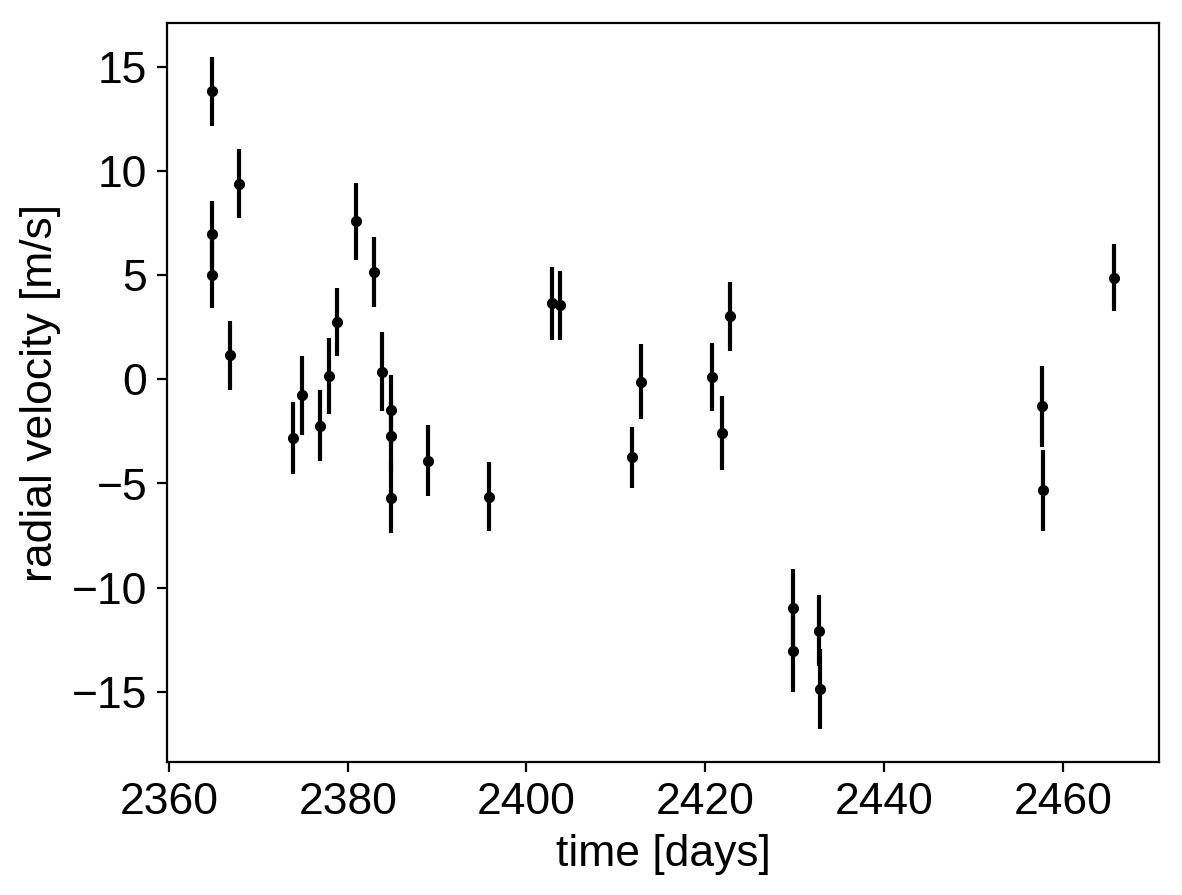

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=2, testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)

    # Define the background model
    A = np.vander(x - 0.5 * (x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))

    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5 * (x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic(
        "rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred
    )

Now, we can plot the initial model:

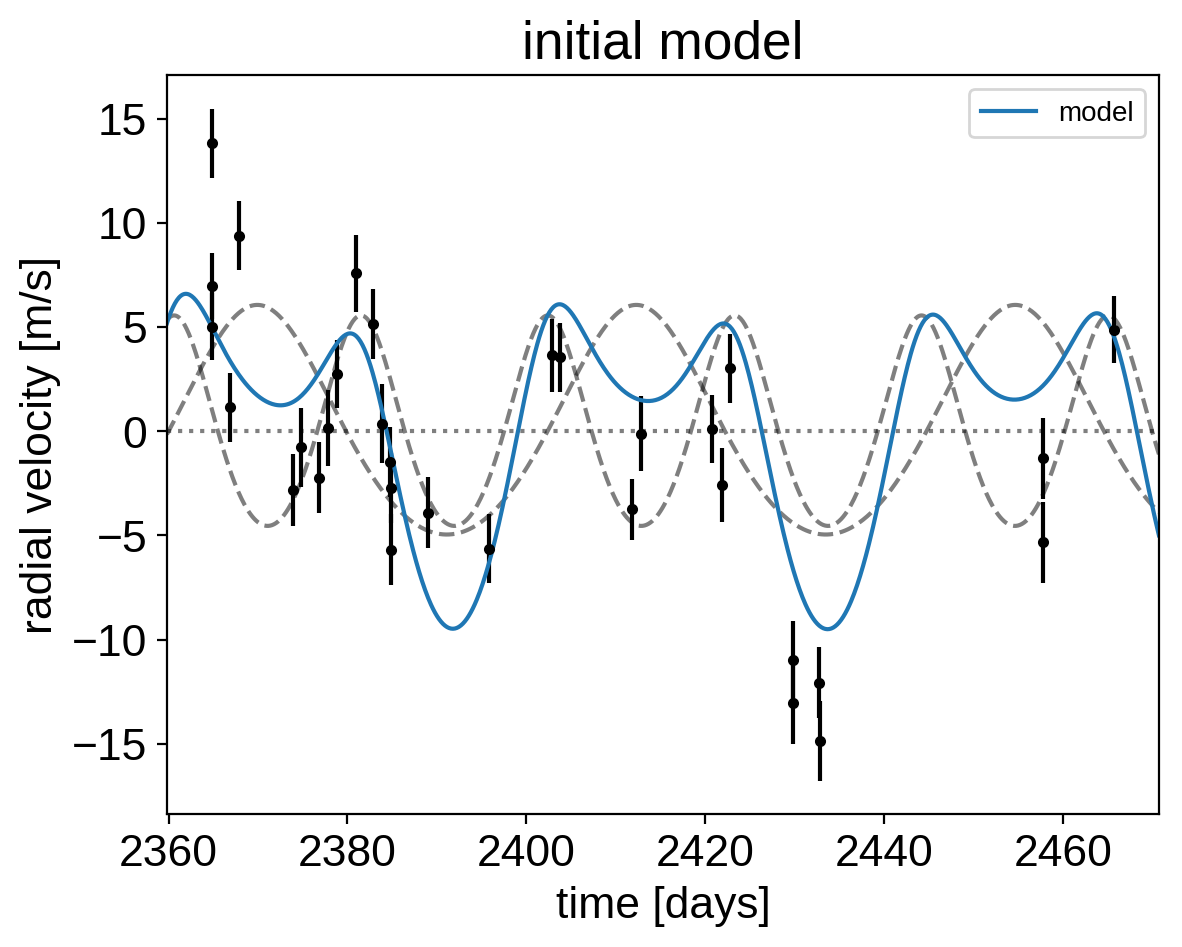

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:

    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 272.66it/s, logp=-7.973266e+01]

2it [00:00, 380.18it/s, logp=-7.973266e+01]

3it [00:00, 396.69it/s, logp=-5.305392e+06]

4it [00:00, 417.19it/s, logp=-7.966783e+01]

5it [00:00, 420.83it/s, logp=-7.953812e+01]

6it [00:00, 414.61it/s, logp=-7.904438e+01]

7it [00:00, 427.68it/s, logp=-7.747076e+01]

8it [00:00, 430.14it/s, logp=-7.344108e+01]

9it [00:00, 431.25it/s, logp=-6.722892e+01]

10it [00:00, 422.74it/s, logp=-6.484820e+01]

11it [00:00, 403.17it/s, logp=-6.484820e+01]

12it [00:00, 392.23it/s, logp=-6.484820e+01]

13it [00:03,  3.72it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 170.01it/s, logp=-6.484820e+01]

2it [00:00, 254.19it/s, logp=-6.484820e+01]

3it [00:00, 293.11it/s, logp=-4.990134e+09]

4it [00:00, 311.06it/s, logp=-6.484832e+01]

5it [00:00, 348.02it/s, logp=-6.484777e+01]

6it [00:00, 375.37it/s, logp=-6.519268e+01]

7it [00:00, 403.08it/s, logp=-6.484777e+01]

8it [00:00, 427.50it/s, logp=-6.484777e+01]

9it [00:00, 452.43it/s, logp=-6.484776e+01]

10it [00:00, 474.28it/s, logp=-6.484774e+01]

11it [00:00, 492.35it/s, logp=-6.484767e+01]

12it [00:00, 507.12it/s, logp=-6.484739e+01]

13it [00:00, 521.79it/s, logp=-6.484633e+01]

14it [00:00, 525.62it/s, logp=-6.484353e+01]

15it [00:00, 531.34it/s, logp=-6.483426e+01]

16it [00:00, 537.96it/s, logp=-6.481055e+01]

17it [00:00, 550.04it/s, logp=-6.472940e+01]

18it [00:00, 551.98it/s, logp=-6.451928e+01]

19it [00:00, 560.70it/s, logp=-6.371170e+01]

20it [00:00, 568.29it/s, logp=-6.096678e+01]

21it [00:00, 566.95it/s, logp=-5.708652e+01]

22it [00:00, 569.78it/s, logp=-5.027536e+01]

23it [00:00, 571.29it/s, logp=-2.386568e+02]

24it [00:00, 571.84it/s, logp=-4.912172e+01]

25it [00:00, 572.13it/s, logp=-4.707357e+01]

26it [00:00, 573.98it/s, logp=-4.319328e+01]

27it [00:00, 574.45it/s, logp=-3.608487e+01]

28it [00:00, 577.88it/s, logp=-2.498567e+01]

29it [00:00, 578.26it/s, logp=-2.442071e+01]

30it [00:00, 578.58it/s, logp=-2.333036e+01]

31it [00:00, 582.82it/s, logp=-2.011091e+01]

32it [00:00, 584.39it/s, logp=-1.751350e+01]

33it [00:00, 586.05it/s, logp=-1.714559e+01]

34it [00:00, 587.72it/s, logp=-1.693796e+01]

35it [00:00, 587.96it/s, logp=-1.684943e+01]

36it [00:00, 587.93it/s, logp=-1.676095e+01]

37it [00:00, 587.80it/s, logp=-1.673569e+01]

38it [00:00, 588.36it/s, logp=-1.672214e+01]

39it [00:00, 588.61it/s, logp=-1.670758e+01]

40it [00:00, 587.24it/s, logp=-1.668064e+01]

41it [00:00, 586.11it/s, logp=-1.662858e+01]

42it [00:00, 586.96it/s, logp=-1.658058e+01]

43it [00:00, 586.95it/s, logp=-1.655728e+01]

44it [00:00, 587.08it/s, logp=-1.662929e+01]

45it [00:00, 587.57it/s, logp=-1.647872e+01]

46it [00:00, 585.39it/s, logp=-1.635178e+01]

47it [00:00, 584.51it/s, logp=-1.613280e+01]

48it [00:00, 585.75it/s, logp=-1.577352e+01]

49it [00:00, 584.78it/s, logp=-1.525205e+01]

50it [00:00, 583.75it/s, logp=-1.849895e+01]

51it [00:00, 584.52it/s, logp=-1.514689e+01]

52it [00:00, 583.55it/s, logp=-1.501721e+01]

53it [00:00, 582.32it/s, logp=-1.496658e+01]

54it [00:00, 580.66it/s, logp=-1.495457e+01]

55it [00:00, 577.99it/s, logp=-1.494704e+01]

56it [00:00, 576.22it/s, logp=-1.494509e+01]

57it [00:00, 575.27it/s, logp=-1.494181e+01]

58it [00:00, 574.77it/s, logp=-1.493619e+01]

59it [00:00, 581.37it/s, logp=-1.493619e+01]

59it [00:00, 581.37it/s, logp=-1.492655e+01]

60it [00:00, 581.37it/s, logp=-1.491151e+01]

61it [00:00, 581.37it/s, logp=-1.489345e+01]

62it [00:00, 581.37it/s, logp=-1.486580e+01]

63it [00:00, 581.37it/s, logp=-1.483881e+01]

64it [00:00, 581.37it/s, logp=-1.479783e+01]

65it [00:00, 581.37it/s, logp=-1.475797e+01]

66it [00:00, 581.37it/s, logp=-1.470224e+01]

67it [00:00, 581.37it/s, logp=-1.466581e+01]

68it [00:00, 581.37it/s, logp=-1.465792e+01]

69it [00:00, 581.37it/s, logp=-1.460984e+01]

70it [00:00, 581.37it/s, logp=-1.453216e+01]

71it [00:00, 581.37it/s, logp=-1.441150e+01]

72it [00:00, 581.37it/s, logp=-1.431230e+01]

73it [00:00, 581.37it/s, logp=-1.436794e+01]

74it [00:00, 581.37it/s, logp=-1.429690e+01]

75it [00:00, 581.37it/s, logp=-1.428194e+01]

76it [00:00, 581.37it/s, logp=-1.427769e+01]

77it [00:00, 581.37it/s, logp=-1.427703e+01]

78it [00:00, 581.37it/s, logp=-1.427688e+01]

79it [00:00, 581.37it/s, logp=-1.427678e+01]

80it [00:00, 581.37it/s, logp=-1.427677e+01]

81it [00:00, 581.37it/s, logp=-1.427676e+01]

82it [00:00, 581.37it/s, logp=-1.427676e+01]

83it [00:00, 581.37it/s, logp=-1.427676e+01]

84it [00:00, 581.37it/s, logp=-1.427676e+01]

85it [00:00, 581.37it/s, logp=-1.427676e+01]

86it [00:00, 581.37it/s, logp=-1.427676e+01]

87it [00:00, 581.37it/s, logp=-1.427676e+01]

88it [00:00, 581.37it/s, logp=-1.427676e+01]

89it [00:00, 581.37it/s, logp=-1.427676e+01]

90it [00:00, 581.37it/s, logp=-1.427676e+01]

91it [00:00, 581.37it/s, logp=-1.427676e+01]

92it [00:00, 581.37it/s, logp=-1.427676e+01]

93it [00:00, 581.37it/s, logp=-1.427676e+01]

94it [00:00, 195.29it/s, logp=-1.427676e+01]


message: Optimization terminated successfully.
logp: -64.8482026233154 -> -14.276760262380932


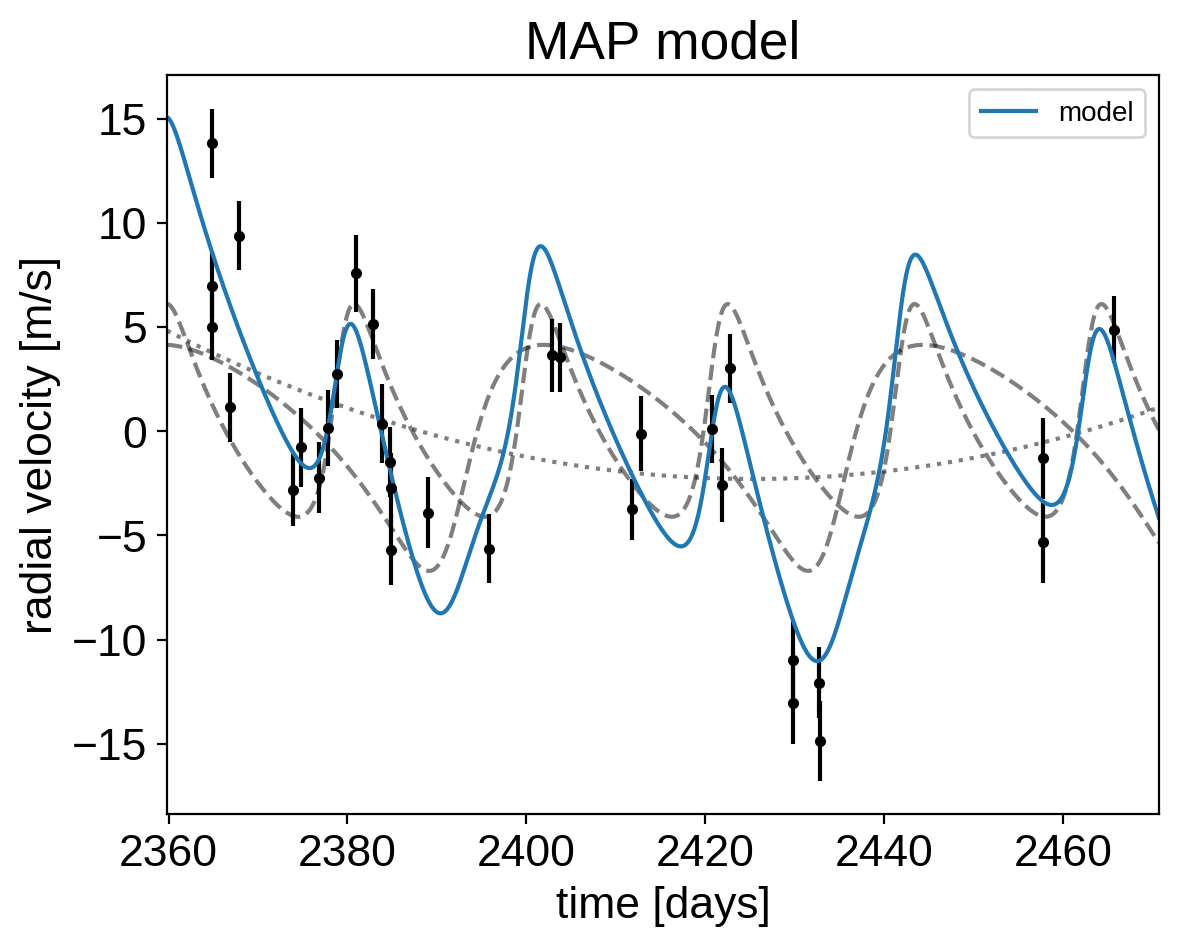

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000, draws=4000, step=xo.get_dense_nuts_step(target_accept=0.95)
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 19/32000 [00:00<02:54, 183.61draws/s]

Sampling 4 chains:   0%|          | 25/32000 [00:00<04:43, 112.72draws/s]

Sampling 4 chains:   0%|          | 31/32000 [00:00<06:42, 79.38draws/s] 

Sampling 4 chains:   0%|          | 37/32000 [00:00<07:37, 69.92draws/s]

Sampling 4 chains:   0%|          | 43/32000 [00:00<08:04, 65.92draws/s]

Sampling 4 chains:   0%|          | 50/32000 [00:00<09:10, 58.02draws/s]

Sampling 4 chains:   0%|          | 57/32000 [00:00<08:43, 61.02draws/s]

Sampling 4 chains:   0%|          | 63/32000 [00:00<09:03, 58.80draws/s]

Sampling 4 chains:   0%|          | 69/32000 [00:01<09:19, 57.05draws/s]

Sampling 4 chains:   0%|          | 77/32000 [00:01<08:53, 59.86draws/s]

Sampling 4 chains:   0%|          | 83/32000 [00:01<09:18, 57.13draws/s]

Sampling 4 chains:   0%|          | 90/32000 [00:01<08:51, 60.02draws/s]

Sampling 4 chains:   0%|          | 97/32000 [00:01<09:16, 57.38draws/s]

Sampling 4 chains:   0%|          | 103/32000 [00:01<09:26, 56.33draws/s]

Sampling 4 chains:   0%|          | 110/32000 [00:01<09:28, 56.12draws/s]

Sampling 4 chains:   0%|          | 117/32000 [00:01<09:10, 57.94draws/s]

Sampling 4 chains:   0%|          | 125/32000 [00:01<08:55, 59.56draws/s]

Sampling 4 chains:   0%|          | 132/32000 [00:02<08:58, 59.14draws/s]

Sampling 4 chains:   0%|          | 140/32000 [00:02<08:51, 59.99draws/s]

Sampling 4 chains:   0%|          | 147/32000 [00:02<09:24, 56.44draws/s]

Sampling 4 chains:   0%|          | 155/32000 [00:02<09:21, 56.68draws/s]

Sampling 4 chains:   1%|          | 162/32000 [00:02<09:32, 55.57draws/s]

Sampling 4 chains:   1%|          | 170/32000 [00:02<09:33, 55.52draws/s]

Sampling 4 chains:   1%|          | 177/32000 [00:02<09:00, 58.92draws/s]

Sampling 4 chains:   1%|          | 183/32000 [00:02<09:00, 58.88draws/s]

Sampling 4 chains:   1%|          | 189/32000 [00:03<09:33, 55.48draws/s]

Sampling 4 chains:   1%|          | 196/32000 [00:03<09:15, 57.24draws/s]

Sampling 4 chains:   1%|          | 203/32000 [00:03<09:08, 57.94draws/s]

Sampling 4 chains:   1%|          | 209/32000 [00:03<09:04, 58.42draws/s]

Sampling 4 chains:   1%|          | 215/32000 [00:03<09:17, 57.02draws/s]

Sampling 4 chains:   1%|          | 222/32000 [00:03<09:06, 58.12draws/s]

Sampling 4 chains:   1%|          | 228/32000 [00:03<09:02, 58.62draws/s]

Sampling 4 chains:   1%|          | 234/32000 [00:03<09:00, 58.80draws/s]

Sampling 4 chains:   1%|          | 240/32000 [00:03<09:15, 57.15draws/s]

Sampling 4 chains:   1%|          | 247/32000 [00:04<09:13, 57.39draws/s]

Sampling 4 chains:   1%|          | 255/32000 [00:04<08:36, 61.45draws/s]

Sampling 4 chains:   1%|          | 262/32000 [00:04<08:34, 61.69draws/s]

Sampling 4 chains:   1%|          | 269/32000 [00:04<08:35, 61.53draws/s]

Sampling 4 chains:   1%|          | 276/32000 [00:04<08:53, 59.42draws/s]

Sampling 4 chains:   1%|          | 282/32000 [00:04<09:18, 56.81draws/s]

Sampling 4 chains:   1%|          | 289/32000 [00:04<09:10, 57.63draws/s]

Sampling 4 chains:   1%|          | 296/32000 [00:04<09:05, 58.08draws/s]

Sampling 4 chains:   1%|          | 303/32000 [00:05<08:54, 59.26draws/s]

Sampling 4 chains:   1%|          | 310/32000 [00:05<09:38, 54.75draws/s]

Sampling 4 chains:   1%|          | 318/32000 [00:05<08:58, 58.86draws/s]

Sampling 4 chains:   1%|          | 325/32000 [00:05<09:03, 58.30draws/s]

Sampling 4 chains:   1%|          | 331/32000 [00:05<08:59, 58.75draws/s]

Sampling 4 chains:   1%|          | 337/32000 [00:05<09:05, 58.03draws/s]

Sampling 4 chains:   1%|          | 345/32000 [00:05<08:37, 61.11draws/s]

Sampling 4 chains:   1%|          | 352/32000 [00:05<09:30, 55.48draws/s]

Sampling 4 chains:   1%|          | 359/32000 [00:05<09:09, 57.59draws/s]

Sampling 4 chains:   1%|          | 365/32000 [00:06<09:13, 57.16draws/s]

Sampling 4 chains:   1%|          | 373/32000 [00:06<09:31, 55.39draws/s]

Sampling 4 chains:   1%|          | 381/32000 [00:06<09:01, 58.40draws/s]

Sampling 4 chains:   1%|          | 389/32000 [00:06<08:40, 60.79draws/s]

Sampling 4 chains:   1%|          | 396/32000 [00:06<08:29, 62.01draws/s]

Sampling 4 chains:   1%|▏         | 403/32000 [00:06<08:28, 62.14draws/s]

Sampling 4 chains:   1%|▏         | 410/32000 [00:06<08:49, 59.67draws/s]

Sampling 4 chains:   1%|▏         | 417/32000 [00:06<09:15, 56.82draws/s]

Sampling 4 chains:   1%|▏         | 424/32000 [00:07<09:11, 57.24draws/s]

Sampling 4 chains:   1%|▏         | 432/32000 [00:07<09:11, 57.25draws/s]

Sampling 4 chains:   1%|▏         | 440/32000 [00:07<09:03, 58.12draws/s]

Sampling 4 chains:   1%|▏         | 447/32000 [00:07<08:51, 59.42draws/s]

Sampling 4 chains:   1%|▏         | 455/32000 [00:07<09:01, 58.22draws/s]

Sampling 4 chains:   1%|▏         | 463/32000 [00:07<08:50, 59.46draws/s]

Sampling 4 chains:   1%|▏         | 470/32000 [00:07<08:35, 61.20draws/s]

Sampling 4 chains:   1%|▏         | 477/32000 [00:07<08:53, 59.05draws/s]

Sampling 4 chains:   2%|▏         | 483/32000 [00:08<09:18, 56.40draws/s]

Sampling 4 chains:   2%|▏         | 491/32000 [00:08<08:53, 59.09draws/s]

Sampling 4 chains:   2%|▏         | 498/32000 [00:08<08:52, 59.14draws/s]

Sampling 4 chains:   2%|▏         | 505/32000 [00:08<08:43, 60.13draws/s]

Sampling 4 chains:   2%|▏         | 512/32000 [00:08<08:29, 61.78draws/s]

Sampling 4 chains:   2%|▏         | 519/32000 [00:08<08:51, 59.19draws/s]

Sampling 4 chains:   2%|▏         | 525/32000 [00:08<09:29, 55.24draws/s]

Sampling 4 chains:   2%|▏         | 531/32000 [00:08<09:48, 53.48draws/s]

Sampling 4 chains:   2%|▏         | 538/32000 [00:09<09:06, 57.54draws/s]

Sampling 4 chains:   2%|▏         | 544/32000 [00:09<09:12, 56.92draws/s]

Sampling 4 chains:   2%|▏         | 550/32000 [00:09<09:30, 55.11draws/s]

Sampling 4 chains:   2%|▏         | 556/32000 [00:09<09:45, 53.72draws/s]

Sampling 4 chains:   2%|▏         | 563/32000 [00:09<09:13, 56.79draws/s]

Sampling 4 chains:   2%|▏         | 569/32000 [00:09<09:12, 56.86draws/s]

Sampling 4 chains:   2%|▏         | 576/32000 [00:09<09:00, 58.13draws/s]

Sampling 4 chains:   2%|▏         | 582/32000 [00:09<09:00, 58.10draws/s]

Sampling 4 chains:   2%|▏         | 589/32000 [00:09<08:49, 59.27draws/s]

Sampling 4 chains:   2%|▏         | 595/32000 [00:10<09:13, 56.77draws/s]

Sampling 4 chains:   2%|▏         | 602/32000 [00:10<09:13, 56.76draws/s]

Sampling 4 chains:   2%|▏         | 609/32000 [00:10<09:09, 57.15draws/s]

Sampling 4 chains:   2%|▏         | 616/32000 [00:10<08:49, 59.31draws/s]

Sampling 4 chains:   2%|▏         | 623/32000 [00:10<08:34, 60.96draws/s]

Sampling 4 chains:   2%|▏         | 630/32000 [00:10<08:54, 58.73draws/s]

Sampling 4 chains:   2%|▏         | 637/32000 [00:10<09:02, 57.86draws/s]

Sampling 4 chains:   2%|▏         | 645/32000 [00:10<08:43, 59.87draws/s]

Sampling 4 chains:   2%|▏         | 652/32000 [00:10<08:21, 62.53draws/s]

Sampling 4 chains:   2%|▏         | 659/32000 [00:11<08:40, 60.26draws/s]

Sampling 4 chains:   2%|▏         | 667/32000 [00:11<08:46, 59.55draws/s]

Sampling 4 chains:   2%|▏         | 674/32000 [00:11<08:28, 61.66draws/s]

Sampling 4 chains:   2%|▏         | 681/32000 [00:11<08:45, 59.62draws/s]

Sampling 4 chains:   2%|▏         | 688/32000 [00:11<09:00, 57.94draws/s]

Sampling 4 chains:   2%|▏         | 695/32000 [00:11<09:06, 57.25draws/s]

Sampling 4 chains:   2%|▏         | 702/32000 [00:11<08:39, 60.20draws/s]

Sampling 4 chains:   2%|▏         | 709/32000 [00:11<08:35, 60.66draws/s]

Sampling 4 chains:   2%|▏         | 716/32000 [00:12<08:36, 60.58draws/s]

Sampling 4 chains:   2%|▏         | 723/32000 [00:12<08:39, 60.20draws/s]

Sampling 4 chains:   2%|▏         | 731/32000 [00:12<08:28, 61.54draws/s]

Sampling 4 chains:   2%|▏         | 738/32000 [00:12<08:15, 63.07draws/s]

Sampling 4 chains:   2%|▏         | 745/32000 [00:12<08:35, 60.58draws/s]

Sampling 4 chains:   2%|▏         | 752/32000 [00:12<08:27, 61.62draws/s]

Sampling 4 chains:   2%|▏         | 760/32000 [00:12<07:56, 65.62draws/s]

Sampling 4 chains:   2%|▏         | 768/32000 [00:12<07:51, 66.26draws/s]

Sampling 4 chains:   2%|▏         | 776/32000 [00:12<07:53, 65.99draws/s]

Sampling 4 chains:   2%|▏         | 784/32000 [00:13<07:33, 68.86draws/s]

Sampling 4 chains:   2%|▏         | 791/32000 [00:13<08:50, 58.83draws/s]

Sampling 4 chains:   2%|▏         | 798/32000 [00:13<09:16, 56.05draws/s]

Sampling 4 chains:   3%|▎         | 804/32000 [00:13<09:14, 56.26draws/s]

Sampling 4 chains:   3%|▎         | 810/32000 [00:13<09:40, 53.75draws/s]

Sampling 4 chains:   3%|▎         | 816/32000 [00:13<13:21, 38.89draws/s]

Sampling 4 chains:   3%|▎         | 821/32000 [00:13<12:30, 41.55draws/s]

Sampling 4 chains:   3%|▎         | 828/32000 [00:14<11:10, 46.52draws/s]

Sampling 4 chains:   3%|▎         | 835/32000 [00:14<10:11, 51.00draws/s]

Sampling 4 chains:   3%|▎         | 845/32000 [00:14<08:47, 59.08draws/s]

Sampling 4 chains:   3%|▎         | 861/32000 [00:14<07:13, 71.90draws/s]

Sampling 4 chains:   3%|▎         | 871/32000 [00:14<07:05, 73.15draws/s]

Sampling 4 chains:   3%|▎         | 880/32000 [00:14<06:55, 74.87draws/s]

Sampling 4 chains:   3%|▎         | 890/32000 [00:14<06:27, 80.37draws/s]

Sampling 4 chains:   3%|▎         | 904/32000 [00:14<05:41, 91.15draws/s]

Sampling 4 chains:   3%|▎         | 920/32000 [00:14<05:05, 101.89draws/s]

Sampling 4 chains:   3%|▎         | 932/32000 [00:15<05:09, 100.32draws/s]

Sampling 4 chains:   3%|▎         | 949/32000 [00:15<04:33, 113.43draws/s]

Sampling 4 chains:   3%|▎         | 964/32000 [00:15<04:13, 122.37draws/s]

Sampling 4 chains:   3%|▎         | 980/32000 [00:15<03:59, 129.34draws/s]

Sampling 4 chains:   3%|▎         | 997/32000 [00:15<03:49, 135.38draws/s]

Sampling 4 chains:   3%|▎         | 1012/32000 [00:15<03:57, 130.39draws/s]

Sampling 4 chains:   3%|▎         | 1027/32000 [00:15<03:49, 134.85draws/s]

Sampling 4 chains:   3%|▎         | 1047/32000 [00:15<03:29, 147.55draws/s]

Sampling 4 chains:   3%|▎         | 1066/32000 [00:15<03:15, 157.95draws/s]

Sampling 4 chains:   3%|▎         | 1086/32000 [00:16<03:04, 167.94draws/s]

Sampling 4 chains:   3%|▎         | 1104/32000 [00:16<03:02, 169.02draws/s]

Sampling 4 chains:   4%|▎         | 1124/32000 [00:16<02:55, 176.20draws/s]

Sampling 4 chains:   4%|▎         | 1146/32000 [00:16<02:48, 183.65draws/s]

Sampling 4 chains:   4%|▎         | 1165/32000 [00:16<03:08, 163.48draws/s]

Sampling 4 chains:   4%|▎         | 1183/32000 [00:16<03:27, 148.27draws/s]

Sampling 4 chains:   4%|▍         | 1201/32000 [00:16<03:19, 154.64draws/s]

Sampling 4 chains:   4%|▍         | 1218/32000 [00:16<03:19, 154.02draws/s]

Sampling 4 chains:   4%|▍         | 1237/32000 [00:16<03:10, 161.24draws/s]

Sampling 4 chains:   4%|▍         | 1256/32000 [00:17<03:04, 166.22draws/s]

Sampling 4 chains:   4%|▍         | 1274/32000 [00:17<03:02, 168.66draws/s]

Sampling 4 chains:   4%|▍         | 1292/32000 [00:17<03:04, 166.37draws/s]

Sampling 4 chains:   4%|▍         | 1311/32000 [00:17<02:57, 172.73draws/s]

Sampling 4 chains:   4%|▍         | 1331/32000 [00:17<02:52, 177.65draws/s]

Sampling 4 chains:   4%|▍         | 1356/32000 [00:17<02:41, 190.22draws/s]

Sampling 4 chains:   4%|▍         | 1384/32000 [00:17<02:27, 207.33draws/s]

Sampling 4 chains:   4%|▍         | 1412/32000 [00:17<02:16, 223.68draws/s]

Sampling 4 chains:   5%|▍         | 1444/32000 [00:17<02:04, 245.77draws/s]

Sampling 4 chains:   5%|▍         | 1472/32000 [00:18<02:00, 252.77draws/s]

Sampling 4 chains:   5%|▍         | 1499/32000 [00:18<02:20, 217.03draws/s]

Sampling 4 chains:   5%|▍         | 1523/32000 [00:18<02:20, 217.39draws/s]

Sampling 4 chains:   5%|▍         | 1546/32000 [00:18<02:19, 218.45draws/s]

Sampling 4 chains:   5%|▍         | 1569/32000 [00:18<02:17, 220.67draws/s]

Sampling 4 chains:   5%|▍         | 1592/32000 [00:18<02:27, 205.96draws/s]

Sampling 4 chains:   5%|▌         | 1614/32000 [00:18<02:28, 204.72draws/s]

Sampling 4 chains:   5%|▌         | 1635/32000 [00:18<02:30, 201.20draws/s]

Sampling 4 chains:   5%|▌         | 1656/32000 [00:18<02:29, 202.46draws/s]

Sampling 4 chains:   5%|▌         | 1677/32000 [00:19<02:31, 200.77draws/s]

Sampling 4 chains:   5%|▌         | 1698/32000 [00:19<02:36, 193.73draws/s]

Sampling 4 chains:   5%|▌         | 1718/32000 [00:19<02:43, 185.60draws/s]

Sampling 4 chains:   5%|▌         | 1737/32000 [00:19<02:42, 185.97draws/s]

Sampling 4 chains:   5%|▌         | 1756/32000 [00:19<03:00, 167.34draws/s]

Sampling 4 chains:   6%|▌         | 1774/32000 [00:19<03:13, 155.86draws/s]

Sampling 4 chains:   6%|▌         | 1794/32000 [00:19<03:02, 165.47draws/s]

Sampling 4 chains:   6%|▌         | 1815/32000 [00:19<02:51, 176.16draws/s]

Sampling 4 chains:   6%|▌         | 1838/32000 [00:19<02:42, 186.15draws/s]

Sampling 4 chains:   6%|▌         | 1860/32000 [00:20<02:36, 192.70draws/s]

Sampling 4 chains:   6%|▌         | 1886/32000 [00:20<02:27, 203.95draws/s]

Sampling 4 chains:   6%|▌         | 1916/32000 [00:20<02:14, 223.63draws/s]

Sampling 4 chains:   6%|▌         | 1946/32000 [00:20<02:04, 241.55draws/s]

Sampling 4 chains:   6%|▌         | 1972/32000 [00:20<02:08, 232.82draws/s]

Sampling 4 chains:   6%|▌         | 1997/32000 [00:20<02:07, 235.01draws/s]

Sampling 4 chains:   6%|▋         | 2024/32000 [00:20<02:04, 241.59draws/s]

Sampling 4 chains:   6%|▋         | 2053/32000 [00:20<01:57, 254.30draws/s]

Sampling 4 chains:   7%|▋         | 2084/32000 [00:20<01:52, 266.86draws/s]

Sampling 4 chains:   7%|▋         | 2117/32000 [00:21<01:45, 282.00draws/s]

Sampling 4 chains:   7%|▋         | 2146/32000 [00:21<01:45, 281.81draws/s]

Sampling 4 chains:   7%|▋         | 2175/32000 [00:21<01:58, 251.48draws/s]

Sampling 4 chains:   7%|▋         | 2202/32000 [00:21<01:57, 253.52draws/s]

Sampling 4 chains:   7%|▋         | 2231/32000 [00:21<01:53, 262.85draws/s]

Sampling 4 chains:   7%|▋         | 2258/32000 [00:21<01:57, 254.07draws/s]

Sampling 4 chains:   7%|▋         | 2284/32000 [00:21<01:59, 247.99draws/s]

Sampling 4 chains:   7%|▋         | 2311/32000 [00:21<01:59, 248.44draws/s]

Sampling 4 chains:   7%|▋         | 2337/32000 [00:21<02:03, 240.01draws/s]

Sampling 4 chains:   7%|▋         | 2364/32000 [00:22<02:00, 246.00draws/s]

Sampling 4 chains:   7%|▋         | 2391/32000 [00:22<01:59, 247.23draws/s]

Sampling 4 chains:   8%|▊         | 2416/32000 [00:22<02:08, 231.07draws/s]

Sampling 4 chains:   8%|▊         | 2440/32000 [00:22<02:17, 215.46draws/s]

Sampling 4 chains:   8%|▊         | 2462/32000 [00:22<02:21, 209.49draws/s]

Sampling 4 chains:   8%|▊         | 2492/32000 [00:22<02:08, 229.61draws/s]

Sampling 4 chains:   8%|▊         | 2516/32000 [00:22<02:07, 230.87draws/s]

Sampling 4 chains:   8%|▊         | 2544/32000 [00:22<02:02, 241.30draws/s]

Sampling 4 chains:   8%|▊         | 2578/32000 [00:22<01:52, 260.45draws/s]

Sampling 4 chains:   8%|▊         | 2609/32000 [00:23<01:48, 271.09draws/s]

Sampling 4 chains:   8%|▊         | 2637/32000 [00:23<01:52, 260.48draws/s]

Sampling 4 chains:   8%|▊         | 2664/32000 [00:23<01:53, 258.37draws/s]

Sampling 4 chains:   8%|▊         | 2692/32000 [00:23<01:50, 264.42draws/s]

Sampling 4 chains:   8%|▊         | 2719/32000 [00:23<01:50, 264.94draws/s]

Sampling 4 chains:   9%|▊         | 2752/32000 [00:23<01:44, 280.91draws/s]

Sampling 4 chains:   9%|▊         | 2782/32000 [00:23<01:42, 285.34draws/s]

Sampling 4 chains:   9%|▉         | 2811/32000 [00:23<01:44, 279.45draws/s]

Sampling 4 chains:   9%|▉         | 2840/32000 [00:23<01:45, 277.54draws/s]

Sampling 4 chains:   9%|▉         | 2869/32000 [00:23<01:44, 277.84draws/s]

Sampling 4 chains:   9%|▉         | 2901/32000 [00:24<01:41, 286.24draws/s]

Sampling 4 chains:   9%|▉         | 2932/32000 [00:24<01:40, 290.12draws/s]

Sampling 4 chains:   9%|▉         | 2972/32000 [00:24<01:32, 312.90draws/s]

Sampling 4 chains:   9%|▉         | 3004/32000 [00:24<01:36, 300.81draws/s]

Sampling 4 chains:   9%|▉         | 3037/32000 [00:24<01:34, 307.17draws/s]

Sampling 4 chains:  10%|▉         | 3070/32000 [00:24<01:32, 312.95draws/s]

Sampling 4 chains:  10%|▉         | 3104/32000 [00:24<01:30, 320.03draws/s]

Sampling 4 chains:  10%|▉         | 3140/32000 [00:24<01:27, 328.50draws/s]

Sampling 4 chains:  10%|▉         | 3180/32000 [00:24<01:23, 347.04draws/s]

Sampling 4 chains:  10%|█         | 3219/32000 [00:25<01:20, 357.96draws/s]

Sampling 4 chains:  10%|█         | 3256/32000 [00:25<01:21, 354.37draws/s]

Sampling 4 chains:  10%|█         | 3296/32000 [00:25<01:18, 364.79draws/s]

Sampling 4 chains:  10%|█         | 3341/32000 [00:25<01:14, 386.44draws/s]

Sampling 4 chains:  11%|█         | 3382/32000 [00:25<01:13, 390.73draws/s]

Sampling 4 chains:  11%|█         | 3427/32000 [00:25<01:10, 406.34draws/s]

Sampling 4 chains:  11%|█         | 3473/32000 [00:25<01:07, 420.05draws/s]

Sampling 4 chains:  11%|█         | 3519/32000 [00:25<01:06, 429.86draws/s]

Sampling 4 chains:  11%|█         | 3563/32000 [00:25<01:05, 431.68draws/s]

Sampling 4 chains:  11%|█▏        | 3607/32000 [00:25<01:09, 407.16draws/s]

Sampling 4 chains:  11%|█▏        | 3649/32000 [00:26<01:13, 383.63draws/s]

Sampling 4 chains:  12%|█▏        | 3688/32000 [00:26<01:15, 373.67draws/s]

Sampling 4 chains:  12%|█▏        | 3727/32000 [00:26<01:14, 378.03draws/s]

Sampling 4 chains:  12%|█▏        | 3766/32000 [00:26<01:15, 374.07draws/s]

Sampling 4 chains:  12%|█▏        | 3806/32000 [00:26<01:14, 379.00draws/s]

Sampling 4 chains:  12%|█▏        | 3845/32000 [00:26<01:14, 375.53draws/s]

Sampling 4 chains:  12%|█▏        | 3883/32000 [00:26<01:17, 363.08draws/s]

Sampling 4 chains:  12%|█▏        | 3920/32000 [00:26<01:17, 363.85draws/s]

Sampling 4 chains:  12%|█▏        | 3961/32000 [00:26<01:14, 375.59draws/s]

Sampling 4 chains:  13%|█▎        | 4003/32000 [00:27<01:13, 382.43draws/s]

Sampling 4 chains:  13%|█▎        | 4045/32000 [00:27<01:11, 392.13draws/s]

Sampling 4 chains:  13%|█▎        | 4085/32000 [00:27<01:16, 364.74draws/s]

Sampling 4 chains:  13%|█▎        | 4122/32000 [00:27<01:17, 361.77draws/s]

Sampling 4 chains:  13%|█▎        | 4160/32000 [00:27<01:16, 364.60draws/s]

Sampling 4 chains:  13%|█▎        | 4198/32000 [00:27<01:15, 366.49draws/s]

Sampling 4 chains:  13%|█▎        | 4240/32000 [00:27<01:12, 380.91draws/s]

Sampling 4 chains:  13%|█▎        | 4279/32000 [00:27<01:13, 376.33draws/s]

Sampling 4 chains:  13%|█▎        | 4317/32000 [00:27<01:15, 367.33draws/s]

Sampling 4 chains:  14%|█▎        | 4356/32000 [00:27<01:14, 373.32draws/s]

Sampling 4 chains:  14%|█▎        | 4394/32000 [00:28<01:21, 340.37draws/s]

Sampling 4 chains:  14%|█▍        | 4431/32000 [00:28<01:19, 346.26draws/s]

Sampling 4 chains:  14%|█▍        | 4473/32000 [00:28<01:15, 362.68draws/s]

Sampling 4 chains:  14%|█▍        | 4517/32000 [00:28<01:11, 382.34draws/s]

Sampling 4 chains:  14%|█▍        | 4561/32000 [00:28<01:09, 396.30draws/s]

Sampling 4 chains:  14%|█▍        | 4602/32000 [00:28<01:08, 398.68draws/s]

Sampling 4 chains:  15%|█▍        | 4643/32000 [00:28<01:15, 364.61draws/s]

Sampling 4 chains:  15%|█▍        | 4681/32000 [00:28<01:15, 361.04draws/s]

Sampling 4 chains:  15%|█▍        | 4718/32000 [00:29<01:26, 316.91draws/s]

Sampling 4 chains:  15%|█▍        | 4752/32000 [00:29<01:27, 311.77draws/s]

Sampling 4 chains:  15%|█▍        | 4785/32000 [00:29<01:32, 295.72draws/s]

Sampling 4 chains:  15%|█▌        | 4816/32000 [00:29<01:31, 295.61draws/s]

Sampling 4 chains:  15%|█▌        | 4847/32000 [00:29<01:34, 287.60draws/s]

Sampling 4 chains:  15%|█▌        | 4877/32000 [00:29<01:39, 271.79draws/s]

Sampling 4 chains:  15%|█▌        | 4905/32000 [00:29<01:39, 271.69draws/s]

Sampling 4 chains:  15%|█▌        | 4933/32000 [00:29<01:40, 269.52draws/s]

Sampling 4 chains:  16%|█▌        | 4961/32000 [00:29<01:39, 270.46draws/s]

Sampling 4 chains:  16%|█▌        | 4989/32000 [00:30<01:44, 259.13draws/s]

Sampling 4 chains:  16%|█▌        | 5017/32000 [00:30<01:43, 260.02draws/s]

Sampling 4 chains:  16%|█▌        | 5044/32000 [00:30<01:45, 256.32draws/s]

Sampling 4 chains:  16%|█▌        | 5072/32000 [00:30<01:42, 261.61draws/s]

Sampling 4 chains:  16%|█▌        | 5101/32000 [00:30<01:39, 269.09draws/s]

Sampling 4 chains:  16%|█▌        | 5132/32000 [00:30<01:36, 278.90draws/s]

Sampling 4 chains:  16%|█▌        | 5165/32000 [00:30<01:32, 289.35draws/s]

Sampling 4 chains:  16%|█▌        | 5195/32000 [00:30<01:32, 291.02draws/s]

Sampling 4 chains:  16%|█▋        | 5229/32000 [00:30<01:28, 303.50draws/s]

Sampling 4 chains:  16%|█▋        | 5261/32000 [00:30<01:27, 306.19draws/s]

Sampling 4 chains:  17%|█▋        | 5294/32000 [00:31<01:25, 312.05draws/s]

Sampling 4 chains:  17%|█▋        | 5333/32000 [00:31<01:20, 331.06draws/s]

Sampling 4 chains:  17%|█▋        | 5376/32000 [00:31<01:14, 355.54draws/s]

Sampling 4 chains:  17%|█▋        | 5413/32000 [00:31<01:14, 357.92draws/s]

Sampling 4 chains:  17%|█▋        | 5454/32000 [00:31<01:12, 366.69draws/s]

Sampling 4 chains:  17%|█▋        | 5494/32000 [00:31<01:10, 375.57draws/s]

Sampling 4 chains:  17%|█▋        | 5539/32000 [00:31<01:06, 395.07draws/s]

Sampling 4 chains:  17%|█▋        | 5581/32000 [00:31<01:05, 402.20draws/s]

Sampling 4 chains:  18%|█▊        | 5622/32000 [00:31<01:10, 374.35draws/s]

Sampling 4 chains:  18%|█▊        | 5661/32000 [00:31<01:09, 378.26draws/s]

Sampling 4 chains:  18%|█▊        | 5703/32000 [00:32<01:07, 388.22draws/s]

Sampling 4 chains:  18%|█▊        | 5743/32000 [00:32<01:07, 390.26draws/s]

Sampling 4 chains:  18%|█▊        | 5787/32000 [00:32<01:05, 402.03draws/s]

Sampling 4 chains:  18%|█▊        | 5828/32000 [00:32<01:05, 396.69draws/s]

Sampling 4 chains:  18%|█▊        | 5868/32000 [00:32<01:07, 389.05draws/s]

Sampling 4 chains:  18%|█▊        | 5909/32000 [00:32<01:06, 393.09draws/s]

Sampling 4 chains:  19%|█▊        | 5949/32000 [00:32<01:06, 390.22draws/s]

Sampling 4 chains:  19%|█▊        | 5990/32000 [00:32<01:05, 395.29draws/s]

Sampling 4 chains:  19%|█▉        | 6030/32000 [00:32<01:09, 376.12draws/s]

Sampling 4 chains:  19%|█▉        | 6068/32000 [00:33<01:10, 365.31draws/s]

Sampling 4 chains:  19%|█▉        | 6105/32000 [00:33<01:14, 346.55draws/s]

Sampling 4 chains:  19%|█▉        | 6145/32000 [00:33<01:12, 358.77draws/s]

Sampling 4 chains:  19%|█▉        | 6189/32000 [00:33<01:08, 377.08draws/s]

Sampling 4 chains:  19%|█▉        | 6228/32000 [00:33<01:09, 372.61draws/s]

Sampling 4 chains:  20%|█▉        | 6266/32000 [00:33<01:09, 368.19draws/s]

Sampling 4 chains:  20%|█▉        | 6304/32000 [00:33<01:11, 359.08draws/s]

Sampling 4 chains:  20%|█▉        | 6343/32000 [00:33<01:09, 367.80draws/s]

Sampling 4 chains:  20%|█▉        | 6384/32000 [00:33<01:07, 378.15draws/s]

Sampling 4 chains:  20%|██        | 6426/32000 [00:34<01:05, 388.88draws/s]

Sampling 4 chains:  20%|██        | 6466/32000 [00:34<01:05, 391.86draws/s]

Sampling 4 chains:  20%|██        | 6506/32000 [00:34<01:05, 386.66draws/s]

Sampling 4 chains:  20%|██        | 6545/32000 [00:34<01:07, 379.62draws/s]

Sampling 4 chains:  21%|██        | 6590/32000 [00:34<01:03, 397.44draws/s]

Sampling 4 chains:  21%|██        | 6632/32000 [00:34<01:02, 403.01draws/s]

Sampling 4 chains:  21%|██        | 6675/32000 [00:34<01:01, 408.99draws/s]

Sampling 4 chains:  21%|██        | 6717/32000 [00:34<01:04, 389.55draws/s]

Sampling 4 chains:  21%|██        | 6757/32000 [00:34<01:09, 362.33draws/s]

Sampling 4 chains:  21%|██        | 6794/32000 [00:34<01:11, 350.46draws/s]

Sampling 4 chains:  21%|██▏       | 6830/32000 [00:35<01:17, 323.72draws/s]

Sampling 4 chains:  21%|██▏       | 6864/32000 [00:35<01:19, 317.37draws/s]

Sampling 4 chains:  22%|██▏       | 6897/32000 [00:35<01:18, 320.26draws/s]

Sampling 4 chains:  22%|██▏       | 6937/32000 [00:35<01:14, 336.96draws/s]

Sampling 4 chains:  22%|██▏       | 6972/32000 [00:35<01:14, 335.32draws/s]

Sampling 4 chains:  22%|██▏       | 7008/32000 [00:35<01:13, 339.17draws/s]

Sampling 4 chains:  22%|██▏       | 7043/32000 [00:35<01:12, 342.01draws/s]

Sampling 4 chains:  22%|██▏       | 7078/32000 [00:35<01:14, 336.14draws/s]

Sampling 4 chains:  22%|██▏       | 7113/32000 [00:35<01:13, 339.64draws/s]

Sampling 4 chains:  22%|██▏       | 7148/32000 [00:36<01:15, 329.42draws/s]

Sampling 4 chains:  22%|██▏       | 7182/32000 [00:36<01:16, 323.20draws/s]

Sampling 4 chains:  23%|██▎       | 7215/32000 [00:36<01:17, 321.13draws/s]

Sampling 4 chains:  23%|██▎       | 7253/32000 [00:36<01:14, 331.37draws/s]

Sampling 4 chains:  23%|██▎       | 7288/32000 [00:36<01:13, 335.72draws/s]

Sampling 4 chains:  23%|██▎       | 7325/32000 [00:36<01:11, 344.66draws/s]

Sampling 4 chains:  23%|██▎       | 7360/32000 [00:36<01:14, 332.80draws/s]

Sampling 4 chains:  23%|██▎       | 7394/32000 [00:36<01:14, 331.42draws/s]

Sampling 4 chains:  23%|██▎       | 7437/32000 [00:36<01:09, 353.80draws/s]

Sampling 4 chains:  23%|██▎       | 7478/32000 [00:37<01:06, 368.49draws/s]

Sampling 4 chains:  23%|██▎       | 7516/32000 [00:37<01:06, 370.86draws/s]

Sampling 4 chains:  24%|██▎       | 7554/32000 [00:37<01:08, 358.76draws/s]

Sampling 4 chains:  24%|██▎       | 7591/32000 [00:37<01:10, 344.84draws/s]

Sampling 4 chains:  24%|██▍       | 7631/32000 [00:37<01:07, 359.36draws/s]

Sampling 4 chains:  24%|██▍       | 7668/32000 [00:37<01:07, 360.52draws/s]

Sampling 4 chains:  24%|██▍       | 7714/32000 [00:37<01:03, 384.85draws/s]

Sampling 4 chains:  24%|██▍       | 7764/32000 [00:37<00:58, 413.15draws/s]

Sampling 4 chains:  24%|██▍       | 7807/32000 [00:37<00:59, 407.23draws/s]

Sampling 4 chains:  25%|██▍       | 7849/32000 [00:37<01:03, 380.38draws/s]

Sampling 4 chains:  25%|██▍       | 7891/32000 [00:38<01:02, 387.61draws/s]

Sampling 4 chains:  25%|██▍       | 7931/32000 [00:38<01:01, 388.37draws/s]

Sampling 4 chains:  25%|██▍       | 7971/32000 [00:38<01:03, 376.90draws/s]

Sampling 4 chains:  25%|██▌       | 8010/32000 [00:38<01:03, 375.65draws/s]

Sampling 4 chains:  25%|██▌       | 8048/32000 [00:38<01:09, 342.30draws/s]

Sampling 4 chains:  25%|██▌       | 8083/32000 [00:38<01:10, 340.03draws/s]

Sampling 4 chains:  25%|██▌       | 8127/32000 [00:38<01:05, 362.94draws/s]

Sampling 4 chains:  26%|██▌       | 8168/32000 [00:38<01:03, 374.39draws/s]

Sampling 4 chains:  26%|██▌       | 8207/32000 [00:38<01:05, 362.89draws/s]

Sampling 4 chains:  26%|██▌       | 8244/32000 [00:39<01:09, 342.08draws/s]

Sampling 4 chains:  26%|██▌       | 8279/32000 [00:39<01:13, 321.90draws/s]

Sampling 4 chains:  26%|██▌       | 8312/32000 [00:39<01:16, 310.69draws/s]

Sampling 4 chains:  26%|██▌       | 8344/32000 [00:39<01:16, 308.87draws/s]

Sampling 4 chains:  26%|██▌       | 8376/32000 [00:39<01:19, 298.61draws/s]

Sampling 4 chains:  26%|██▋       | 8408/32000 [00:39<01:18, 300.20draws/s]

Sampling 4 chains:  26%|██▋       | 8439/32000 [00:39<01:19, 296.20draws/s]

Sampling 4 chains:  26%|██▋       | 8472/32000 [00:39<01:17, 305.50draws/s]

Sampling 4 chains:  27%|██▋       | 8508/32000 [00:39<01:13, 319.56draws/s]

Sampling 4 chains:  27%|██▋       | 8552/32000 [00:40<01:07, 347.10draws/s]

Sampling 4 chains:  27%|██▋       | 8593/32000 [00:40<01:04, 363.34draws/s]

Sampling 4 chains:  27%|██▋       | 8638/32000 [00:40<01:01, 382.27draws/s]

Sampling 4 chains:  27%|██▋       | 8678/32000 [00:40<01:02, 374.38draws/s]

Sampling 4 chains:  27%|██▋       | 8717/32000 [00:40<01:02, 373.93draws/s]

Sampling 4 chains:  27%|██▋       | 8755/32000 [00:40<01:01, 375.22draws/s]

Sampling 4 chains:  27%|██▋       | 8796/32000 [00:40<01:00, 383.96draws/s]

Sampling 4 chains:  28%|██▊       | 8835/32000 [00:40<01:01, 376.74draws/s]

Sampling 4 chains:  28%|██▊       | 8877/32000 [00:40<00:59, 388.20draws/s]

Sampling 4 chains:  28%|██▊       | 8917/32000 [00:40<01:01, 377.90draws/s]

Sampling 4 chains:  28%|██▊       | 8956/32000 [00:41<01:02, 367.09draws/s]

Sampling 4 chains:  28%|██▊       | 8997/32000 [00:41<01:00, 378.01draws/s]

Sampling 4 chains:  28%|██▊       | 9036/32000 [00:41<01:01, 376.32draws/s]

Sampling 4 chains:  28%|██▊       | 9084/32000 [00:41<00:56, 402.35draws/s]

Sampling 4 chains:  29%|██▊       | 9135/32000 [00:41<00:53, 427.27draws/s]

Sampling 4 chains:  29%|██▊       | 9179/32000 [00:41<00:53, 429.97draws/s]

Sampling 4 chains:  29%|██▉       | 9223/32000 [00:41<00:53, 424.63draws/s]

Sampling 4 chains:  29%|██▉       | 9270/32000 [00:41<00:52, 435.99draws/s]

Sampling 4 chains:  29%|██▉       | 9314/32000 [00:41<00:53, 421.03draws/s]

Sampling 4 chains:  29%|██▉       | 9357/32000 [00:42<00:55, 405.36draws/s]

Sampling 4 chains:  29%|██▉       | 9398/32000 [00:42<01:00, 376.49draws/s]

Sampling 4 chains:  29%|██▉       | 9437/32000 [00:42<00:59, 379.33draws/s]

Sampling 4 chains:  30%|██▉       | 9476/32000 [00:42<00:59, 380.71draws/s]

Sampling 4 chains:  30%|██▉       | 9515/32000 [00:42<00:59, 376.83draws/s]

Sampling 4 chains:  30%|██▉       | 9553/32000 [00:42<00:59, 374.88draws/s]

Sampling 4 chains:  30%|██▉       | 9592/32000 [00:42<00:59, 376.45draws/s]

Sampling 4 chains:  30%|███       | 9633/32000 [00:42<00:59, 378.99draws/s]

Sampling 4 chains:  30%|███       | 9671/32000 [00:42<00:59, 375.42draws/s]

Sampling 4 chains:  30%|███       | 9713/32000 [00:43<00:57, 386.75draws/s]

Sampling 4 chains:  30%|███       | 9752/32000 [00:43<00:57, 385.85draws/s]

Sampling 4 chains:  31%|███       | 9793/32000 [00:43<00:56, 391.71draws/s]

Sampling 4 chains:  31%|███       | 9836/32000 [00:43<00:55, 401.98draws/s]

Sampling 4 chains:  31%|███       | 9882/32000 [00:43<00:53, 416.56draws/s]

Sampling 4 chains:  31%|███       | 9928/32000 [00:43<00:51, 427.83draws/s]

Sampling 4 chains:  31%|███       | 9972/32000 [00:43<00:52, 422.96draws/s]

Sampling 4 chains:  31%|███▏      | 10017/32000 [00:43<00:51, 429.05draws/s]

Sampling 4 chains:  31%|███▏      | 10061/32000 [00:43<00:53, 406.88draws/s]

Sampling 4 chains:  32%|███▏      | 10103/32000 [00:43<00:54, 398.85draws/s]

Sampling 4 chains:  32%|███▏      | 10144/32000 [00:44<00:56, 388.30draws/s]

Sampling 4 chains:  32%|███▏      | 10184/32000 [00:44<00:59, 366.40draws/s]

Sampling 4 chains:  32%|███▏      | 10222/32000 [00:44<01:02, 346.84draws/s]

Sampling 4 chains:  32%|███▏      | 10258/32000 [00:44<01:06, 329.38draws/s]

Sampling 4 chains:  32%|███▏      | 10292/32000 [00:44<01:05, 332.02draws/s]

Sampling 4 chains:  32%|███▏      | 10328/32000 [00:44<01:03, 339.92draws/s]

Sampling 4 chains:  32%|███▏      | 10363/32000 [00:44<01:03, 339.79draws/s]

Sampling 4 chains:  33%|███▎      | 10401/32000 [00:44<01:01, 349.88draws/s]

Sampling 4 chains:  33%|███▎      | 10439/32000 [00:44<01:01, 352.46draws/s]

Sampling 4 chains:  33%|███▎      | 10483/32000 [00:45<00:57, 374.05draws/s]

Sampling 4 chains:  33%|███▎      | 10528/32000 [00:45<00:54, 393.20draws/s]

Sampling 4 chains:  33%|███▎      | 10572/32000 [00:45<00:52, 404.36draws/s]

Sampling 4 chains:  33%|███▎      | 10613/32000 [00:45<00:53, 399.24draws/s]

Sampling 4 chains:  33%|███▎      | 10654/32000 [00:45<00:57, 368.69draws/s]

Sampling 4 chains:  33%|███▎      | 10692/32000 [00:45<01:00, 354.25draws/s]

Sampling 4 chains:  34%|███▎      | 10732/32000 [00:45<00:58, 364.33draws/s]

Sampling 4 chains:  34%|███▎      | 10777/32000 [00:45<00:55, 385.82draws/s]

Sampling 4 chains:  34%|███▍      | 10817/32000 [00:45<00:54, 385.76draws/s]

Sampling 4 chains:  34%|███▍      | 10859/32000 [00:46<00:53, 392.78draws/s]

Sampling 4 chains:  34%|███▍      | 10903/32000 [00:46<00:52, 402.92draws/s]

Sampling 4 chains:  34%|███▍      | 10948/32000 [00:46<00:51, 411.00draws/s]

Sampling 4 chains:  34%|███▍      | 10990/32000 [00:46<00:51, 406.31draws/s]

Sampling 4 chains:  34%|███▍      | 11031/32000 [00:46<00:52, 397.64draws/s]

Sampling 4 chains:  35%|███▍      | 11074/32000 [00:46<00:51, 404.94draws/s]

Sampling 4 chains:  35%|███▍      | 11117/32000 [00:46<00:50, 409.92draws/s]

Sampling 4 chains:  35%|███▍      | 11159/32000 [00:46<00:52, 395.27draws/s]

Sampling 4 chains:  35%|███▍      | 11199/32000 [00:46<00:53, 386.44draws/s]

Sampling 4 chains:  35%|███▌      | 11241/32000 [00:46<00:52, 395.32draws/s]

Sampling 4 chains:  35%|███▌      | 11284/32000 [00:47<00:51, 403.44draws/s]

Sampling 4 chains:  35%|███▌      | 11325/32000 [00:47<00:51, 399.11draws/s]

Sampling 4 chains:  36%|███▌      | 11366/32000 [00:47<00:53, 388.32draws/s]

Sampling 4 chains:  36%|███▌      | 11405/32000 [00:47<00:55, 373.18draws/s]

Sampling 4 chains:  36%|███▌      | 11443/32000 [00:47<00:55, 371.80draws/s]

Sampling 4 chains:  36%|███▌      | 11485/32000 [00:47<00:53, 383.99draws/s]

Sampling 4 chains:  36%|███▌      | 11524/32000 [00:47<00:54, 376.48draws/s]

Sampling 4 chains:  36%|███▌      | 11562/32000 [00:47<00:57, 357.57draws/s]

Sampling 4 chains:  36%|███▌      | 11599/32000 [00:47<00:58, 347.25draws/s]

Sampling 4 chains:  36%|███▋      | 11637/32000 [00:48<00:57, 355.37draws/s]

Sampling 4 chains:  36%|███▋      | 11680/32000 [00:48<00:54, 374.78draws/s]

Sampling 4 chains:  37%|███▋      | 11719/32000 [00:48<00:53, 377.88draws/s]

Sampling 4 chains:  37%|███▋      | 11767/32000 [00:48<00:50, 402.98draws/s]

Sampling 4 chains:  37%|███▋      | 11813/32000 [00:48<00:48, 418.48draws/s]

Sampling 4 chains:  37%|███▋      | 11856/32000 [00:48<00:47, 421.30draws/s]

Sampling 4 chains:  37%|███▋      | 11899/32000 [00:48<00:50, 400.17draws/s]

Sampling 4 chains:  37%|███▋      | 11940/32000 [00:48<00:52, 384.20draws/s]

Sampling 4 chains:  37%|███▋      | 11979/32000 [00:48<00:54, 366.01draws/s]

Sampling 4 chains:  38%|███▊      | 12017/32000 [00:49<00:55, 362.37draws/s]

Sampling 4 chains:  38%|███▊      | 12056/32000 [00:49<00:54, 369.07draws/s]

Sampling 4 chains:  38%|███▊      | 12094/32000 [00:49<00:54, 362.84draws/s]

Sampling 4 chains:  38%|███▊      | 12131/32000 [00:49<00:57, 346.28draws/s]

Sampling 4 chains:  38%|███▊      | 12167/32000 [00:49<00:56, 349.15draws/s]

Sampling 4 chains:  38%|███▊      | 12206/32000 [00:49<00:55, 358.41draws/s]

Sampling 4 chains:  38%|███▊      | 12243/32000 [00:49<00:55, 352.87draws/s]

Sampling 4 chains:  38%|███▊      | 12280/32000 [00:49<00:55, 355.17draws/s]

Sampling 4 chains:  39%|███▊      | 12322/32000 [00:49<00:53, 370.18draws/s]

Sampling 4 chains:  39%|███▊      | 12360/32000 [00:49<00:54, 361.17draws/s]

Sampling 4 chains:  39%|███▊      | 12397/32000 [00:50<00:57, 343.17draws/s]

Sampling 4 chains:  39%|███▉      | 12432/32000 [00:50<00:57, 338.10draws/s]

Sampling 4 chains:  39%|███▉      | 12467/32000 [00:50<00:57, 338.13draws/s]

Sampling 4 chains:  39%|███▉      | 12501/32000 [00:50<00:58, 334.46draws/s]

Sampling 4 chains:  39%|███▉      | 12535/32000 [00:50<00:59, 327.66draws/s]

Sampling 4 chains:  39%|███▉      | 12568/32000 [00:50<01:01, 315.40draws/s]

Sampling 4 chains:  39%|███▉      | 12600/32000 [00:50<01:02, 310.26draws/s]

Sampling 4 chains:  39%|███▉      | 12637/32000 [00:50<00:59, 324.08draws/s]

Sampling 4 chains:  40%|███▉      | 12670/32000 [00:50<01:00, 318.38draws/s]

Sampling 4 chains:  40%|███▉      | 12706/32000 [00:51<00:58, 328.64draws/s]

Sampling 4 chains:  40%|███▉      | 12742/32000 [00:51<00:57, 336.74draws/s]

Sampling 4 chains:  40%|███▉      | 12784/32000 [00:51<00:54, 355.17draws/s]

Sampling 4 chains:  40%|████      | 12827/32000 [00:51<00:51, 374.70draws/s]

Sampling 4 chains:  40%|████      | 12866/32000 [00:51<00:50, 375.57draws/s]

Sampling 4 chains:  40%|████      | 12906/32000 [00:51<00:50, 378.47draws/s]

Sampling 4 chains:  40%|████      | 12945/32000 [00:51<00:51, 373.37draws/s]

Sampling 4 chains:  41%|████      | 12983/32000 [00:51<00:51, 369.83draws/s]

Sampling 4 chains:  41%|████      | 13021/32000 [00:51<00:52, 359.70draws/s]

Sampling 4 chains:  41%|████      | 13058/32000 [00:51<00:52, 361.62draws/s]

Sampling 4 chains:  41%|████      | 13096/32000 [00:52<00:51, 366.37draws/s]

Sampling 4 chains:  41%|████      | 13133/32000 [00:52<00:52, 357.57draws/s]

Sampling 4 chains:  41%|████      | 13169/32000 [00:52<00:52, 357.58draws/s]

Sampling 4 chains:  41%|████▏     | 13206/32000 [00:52<00:52, 360.62draws/s]

Sampling 4 chains:  41%|████▏     | 13248/32000 [00:52<00:50, 373.36draws/s]

Sampling 4 chains:  42%|████▏     | 13286/32000 [00:52<00:50, 370.99draws/s]

Sampling 4 chains:  42%|████▏     | 13324/32000 [00:52<00:51, 365.80draws/s]

Sampling 4 chains:  42%|████▏     | 13361/32000 [00:52<00:52, 352.11draws/s]

Sampling 4 chains:  42%|████▏     | 13397/32000 [00:52<00:54, 343.53draws/s]

Sampling 4 chains:  42%|████▏     | 13432/32000 [00:53<00:54, 341.48draws/s]

Sampling 4 chains:  42%|████▏     | 13467/32000 [00:53<00:54, 338.71draws/s]

Sampling 4 chains:  42%|████▏     | 13503/32000 [00:53<00:53, 343.82draws/s]

Sampling 4 chains:  42%|████▏     | 13538/32000 [00:53<00:53, 343.47draws/s]

Sampling 4 chains:  42%|████▏     | 13573/32000 [00:53<00:54, 338.35draws/s]

Sampling 4 chains:  43%|████▎     | 13607/32000 [00:53<00:55, 328.46draws/s]

Sampling 4 chains:  43%|████▎     | 13640/32000 [00:53<01:02, 293.15draws/s]

Sampling 4 chains:  43%|████▎     | 13671/32000 [00:53<01:08, 269.54draws/s]

Sampling 4 chains:  43%|████▎     | 13700/32000 [00:53<01:07, 271.60draws/s]

Sampling 4 chains:  43%|████▎     | 13728/32000 [00:54<01:07, 271.90draws/s]

Sampling 4 chains:  43%|████▎     | 13756/32000 [00:54<01:06, 272.63draws/s]

Sampling 4 chains:  43%|████▎     | 13785/32000 [00:54<01:06, 273.89draws/s]

Sampling 4 chains:  43%|████▎     | 13817/32000 [00:54<01:03, 284.99draws/s]

Sampling 4 chains:  43%|████▎     | 13846/32000 [00:54<01:05, 279.25draws/s]

Sampling 4 chains:  43%|████▎     | 13875/32000 [00:54<01:08, 262.81draws/s]

Sampling 4 chains:  43%|████▎     | 13902/32000 [00:54<01:09, 260.13draws/s]

Sampling 4 chains:  44%|████▎     | 13930/32000 [00:54<01:08, 265.37draws/s]

Sampling 4 chains:  44%|████▎     | 13958/32000 [00:54<01:07, 269.01draws/s]

Sampling 4 chains:  44%|████▎     | 13990/32000 [00:54<01:03, 282.49draws/s]

Sampling 4 chains:  44%|████▍     | 14025/32000 [00:55<00:59, 299.72draws/s]

Sampling 4 chains:  44%|████▍     | 14060/32000 [00:55<00:57, 312.24draws/s]

Sampling 4 chains:  44%|████▍     | 14093/32000 [00:55<00:56, 317.10draws/s]

Sampling 4 chains:  44%|████▍     | 14129/32000 [00:55<00:54, 327.76draws/s]

Sampling 4 chains:  44%|████▍     | 14164/32000 [00:55<00:53, 333.71draws/s]

Sampling 4 chains:  44%|████▍     | 14206/32000 [00:55<00:50, 354.75draws/s]

Sampling 4 chains:  45%|████▍     | 14246/32000 [00:55<00:48, 366.18draws/s]

Sampling 4 chains:  45%|████▍     | 14284/32000 [00:55<00:49, 360.82draws/s]

Sampling 4 chains:  45%|████▍     | 14325/32000 [00:55<00:47, 372.09draws/s]

Sampling 4 chains:  45%|████▍     | 14369/32000 [00:56<00:45, 386.62draws/s]

Sampling 4 chains:  45%|████▌     | 14411/32000 [00:56<00:44, 396.05draws/s]

Sampling 4 chains:  45%|████▌     | 14453/32000 [00:56<00:43, 401.82draws/s]

Sampling 4 chains:  45%|████▌     | 14495/32000 [00:56<00:43, 404.38draws/s]

Sampling 4 chains:  45%|████▌     | 14536/32000 [00:56<00:43, 402.52draws/s]

Sampling 4 chains:  46%|████▌     | 14577/32000 [00:56<00:44, 393.02draws/s]

Sampling 4 chains:  46%|████▌     | 14620/32000 [00:56<00:43, 397.34draws/s]

Sampling 4 chains:  46%|████▌     | 14663/32000 [00:56<00:42, 406.27draws/s]

Sampling 4 chains:  46%|████▌     | 14708/32000 [00:56<00:41, 417.67draws/s]

Sampling 4 chains:  46%|████▌     | 14750/32000 [00:56<00:41, 413.83draws/s]

Sampling 4 chains:  46%|████▌     | 14792/32000 [00:57<00:41, 414.80draws/s]

Sampling 4 chains:  46%|████▋     | 14835/32000 [00:57<00:41, 416.31draws/s]

Sampling 4 chains:  46%|████▋     | 14877/32000 [00:57<00:43, 390.01draws/s]

Sampling 4 chains:  47%|████▋     | 14917/32000 [00:57<00:45, 378.69draws/s]

Sampling 4 chains:  47%|████▋     | 14956/32000 [00:57<00:45, 373.85draws/s]

Sampling 4 chains:  47%|████▋     | 14994/32000 [00:57<00:48, 349.25draws/s]

Sampling 4 chains:  47%|████▋     | 15030/32000 [00:57<00:50, 334.14draws/s]

Sampling 4 chains:  47%|████▋     | 15064/32000 [00:57<00:51, 327.30draws/s]

Sampling 4 chains:  47%|████▋     | 15101/32000 [00:57<00:50, 337.09draws/s]

Sampling 4 chains:  47%|████▋     | 15138/32000 [00:58<00:48, 345.87draws/s]

Sampling 4 chains:  47%|████▋     | 15180/32000 [00:58<00:46, 364.60draws/s]

Sampling 4 chains:  48%|████▊     | 15222/32000 [00:58<00:44, 377.15draws/s]

Sampling 4 chains:  48%|████▊     | 15268/32000 [00:58<00:42, 391.83draws/s]

Sampling 4 chains:  48%|████▊     | 15324/32000 [00:58<00:38, 429.68draws/s]

Sampling 4 chains:  48%|████▊     | 15369/32000 [00:58<00:38, 432.67draws/s]

Sampling 4 chains:  48%|████▊     | 15414/32000 [00:58<00:40, 409.55draws/s]

Sampling 4 chains:  48%|████▊     | 15460/32000 [00:58<00:39, 422.28draws/s]

Sampling 4 chains:  48%|████▊     | 15506/32000 [00:58<00:38, 432.36draws/s]

Sampling 4 chains:  49%|████▊     | 15550/32000 [00:58<00:38, 421.86draws/s]

Sampling 4 chains:  49%|████▊     | 15593/32000 [00:59<00:39, 416.43draws/s]

Sampling 4 chains:  49%|████▉     | 15635/32000 [00:59<00:40, 403.00draws/s]

Sampling 4 chains:  49%|████▉     | 15676/32000 [00:59<00:41, 395.17draws/s]

Sampling 4 chains:  49%|████▉     | 15716/32000 [00:59<00:42, 381.38draws/s]

Sampling 4 chains:  49%|████▉     | 15758/32000 [00:59<00:41, 389.86draws/s]

Sampling 4 chains:  49%|████▉     | 15798/32000 [00:59<00:41, 389.66draws/s]

Sampling 4 chains:  49%|████▉     | 15838/32000 [00:59<00:42, 380.59draws/s]

Sampling 4 chains:  50%|████▉     | 15882/32000 [00:59<00:40, 394.75draws/s]

Sampling 4 chains:  50%|████▉     | 15925/32000 [00:59<00:39, 401.91draws/s]

Sampling 4 chains:  50%|████▉     | 15966/32000 [01:00<00:40, 396.80draws/s]

Sampling 4 chains:  50%|█████     | 16006/32000 [01:00<00:42, 373.27draws/s]

Sampling 4 chains:  50%|█████     | 16044/32000 [01:00<00:42, 374.46draws/s]

Sampling 4 chains:  50%|█████     | 16084/32000 [01:00<00:42, 373.97draws/s]

Sampling 4 chains:  50%|█████     | 16122/32000 [01:00<00:42, 373.41draws/s]

Sampling 4 chains:  50%|█████     | 16160/32000 [01:00<00:42, 371.90draws/s]

Sampling 4 chains:  51%|█████     | 16199/32000 [01:00<00:42, 374.99draws/s]

Sampling 4 chains:  51%|█████     | 16237/32000 [01:00<00:42, 369.37draws/s]

Sampling 4 chains:  51%|█████     | 16275/32000 [01:00<00:43, 364.71draws/s]

Sampling 4 chains:  51%|█████     | 16313/32000 [01:01<00:42, 368.82draws/s]

Sampling 4 chains:  51%|█████     | 16351/32000 [01:01<00:42, 371.74draws/s]

Sampling 4 chains:  51%|█████     | 16389/32000 [01:01<00:41, 373.15draws/s]

Sampling 4 chains:  51%|█████▏    | 16428/32000 [01:01<00:41, 373.83draws/s]

Sampling 4 chains:  51%|█████▏    | 16469/32000 [01:01<00:40, 383.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16508/32000 [01:01<00:41, 377.54draws/s]

Sampling 4 chains:  52%|█████▏    | 16546/32000 [01:01<00:41, 372.41draws/s]

Sampling 4 chains:  52%|█████▏    | 16588/32000 [01:01<00:40, 384.75draws/s]

Sampling 4 chains:  52%|█████▏    | 16632/32000 [01:01<00:38, 396.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16672/32000 [01:01<00:38, 394.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16713/32000 [01:02<00:38, 399.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16754/32000 [01:02<00:37, 401.75draws/s]

Sampling 4 chains:  52%|█████▏    | 16795/32000 [01:02<00:37, 400.56draws/s]

Sampling 4 chains:  53%|█████▎    | 16836/32000 [01:02<00:38, 393.18draws/s]

Sampling 4 chains:  53%|█████▎    | 16876/32000 [01:02<00:39, 387.25draws/s]

Sampling 4 chains:  53%|█████▎    | 16917/32000 [01:02<00:38, 388.26draws/s]

Sampling 4 chains:  53%|█████▎    | 16956/32000 [01:02<00:39, 376.64draws/s]

Sampling 4 chains:  53%|█████▎    | 16997/32000 [01:02<00:38, 385.86draws/s]

Sampling 4 chains:  53%|█████▎    | 17042/32000 [01:02<00:37, 403.03draws/s]

Sampling 4 chains:  53%|█████▎    | 17090/32000 [01:02<00:35, 423.29draws/s]

Sampling 4 chains:  54%|█████▎    | 17135/32000 [01:03<00:34, 429.31draws/s]

Sampling 4 chains:  54%|█████▎    | 17179/32000 [01:03<00:34, 431.77draws/s]

Sampling 4 chains:  54%|█████▍    | 17224/32000 [01:03<00:34, 433.68draws/s]

Sampling 4 chains:  54%|█████▍    | 17271/32000 [01:03<00:33, 442.12draws/s]

Sampling 4 chains:  54%|█████▍    | 17316/32000 [01:03<00:34, 428.73draws/s]

Sampling 4 chains:  54%|█████▍    | 17360/32000 [01:03<00:34, 430.18draws/s]

Sampling 4 chains:  54%|█████▍    | 17404/32000 [01:03<00:34, 423.19draws/s]

Sampling 4 chains:  55%|█████▍    | 17447/32000 [01:03<00:34, 424.09draws/s]

Sampling 4 chains:  55%|█████▍    | 17490/32000 [01:03<00:34, 418.59draws/s]

Sampling 4 chains:  55%|█████▍    | 17532/32000 [01:04<00:36, 399.80draws/s]

Sampling 4 chains:  55%|█████▍    | 17573/32000 [01:04<00:37, 385.42draws/s]

Sampling 4 chains:  55%|█████▌    | 17619/32000 [01:04<00:35, 404.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17668/32000 [01:04<00:33, 426.95draws/s]

Sampling 4 chains:  55%|█████▌    | 17712/32000 [01:04<00:33, 421.46draws/s]

Sampling 4 chains:  55%|█████▌    | 17756/32000 [01:04<00:33, 425.51draws/s]

Sampling 4 chains:  56%|█████▌    | 17800/32000 [01:04<00:33, 427.90draws/s]

Sampling 4 chains:  56%|█████▌    | 17847/32000 [01:04<00:32, 438.77draws/s]

Sampling 4 chains:  56%|█████▌    | 17892/32000 [01:04<00:33, 427.20draws/s]

Sampling 4 chains:  56%|█████▌    | 17935/32000 [01:04<00:33, 425.53draws/s]

Sampling 4 chains:  56%|█████▌    | 17978/32000 [01:05<00:33, 416.65draws/s]

Sampling 4 chains:  56%|█████▋    | 18020/32000 [01:05<00:34, 409.51draws/s]

Sampling 4 chains:  56%|█████▋    | 18062/32000 [01:05<00:33, 410.44draws/s]

Sampling 4 chains:  57%|█████▋    | 18104/32000 [01:05<00:33, 412.04draws/s]

Sampling 4 chains:  57%|█████▋    | 18146/32000 [01:05<00:33, 410.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18189/32000 [01:05<00:33, 414.93draws/s]

Sampling 4 chains:  57%|█████▋    | 18234/32000 [01:05<00:32, 422.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18277/32000 [01:05<00:33, 411.79draws/s]

Sampling 4 chains:  57%|█████▋    | 18319/32000 [01:05<00:33, 406.27draws/s]

Sampling 4 chains:  57%|█████▋    | 18364/32000 [01:05<00:32, 414.44draws/s]

Sampling 4 chains:  58%|█████▊    | 18409/32000 [01:06<00:32, 419.08draws/s]

Sampling 4 chains:  58%|█████▊    | 18451/32000 [01:06<00:32, 418.84draws/s]

Sampling 4 chains:  58%|█████▊    | 18495/32000 [01:06<00:31, 424.10draws/s]

Sampling 4 chains:  58%|█████▊    | 18541/32000 [01:06<00:31, 434.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18585/32000 [01:06<00:31, 431.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18629/32000 [01:06<00:30, 431.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18674/32000 [01:06<00:30, 434.75draws/s]

Sampling 4 chains:  58%|█████▊    | 18718/32000 [01:06<00:31, 421.84draws/s]

Sampling 4 chains:  59%|█████▊    | 18761/32000 [01:06<00:31, 419.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18803/32000 [01:07<00:32, 406.14draws/s]

Sampling 4 chains:  59%|█████▉    | 18844/32000 [01:07<00:32, 406.78draws/s]

Sampling 4 chains:  59%|█████▉    | 18885/32000 [01:07<00:32, 405.49draws/s]

Sampling 4 chains:  59%|█████▉    | 18927/32000 [01:07<00:31, 409.60draws/s]

Sampling 4 chains:  59%|█████▉    | 18970/32000 [01:07<00:31, 412.32draws/s]

Sampling 4 chains:  59%|█████▉    | 19012/32000 [01:07<00:31, 408.32draws/s]

Sampling 4 chains:  60%|█████▉    | 19056/32000 [01:07<00:31, 416.20draws/s]

Sampling 4 chains:  60%|█████▉    | 19098/32000 [01:07<00:33, 390.29draws/s]

Sampling 4 chains:  60%|█████▉    | 19138/32000 [01:07<00:33, 386.96draws/s]

Sampling 4 chains:  60%|█████▉    | 19179/32000 [01:07<00:32, 393.04draws/s]

Sampling 4 chains:  60%|██████    | 19220/32000 [01:08<00:32, 397.63draws/s]

Sampling 4 chains:  60%|██████    | 19263/32000 [01:08<00:31, 405.20draws/s]

Sampling 4 chains:  60%|██████    | 19310/32000 [01:08<00:30, 420.81draws/s]

Sampling 4 chains:  60%|██████    | 19353/32000 [01:08<00:30, 408.35draws/s]

Sampling 4 chains:  61%|██████    | 19395/32000 [01:08<00:31, 404.23draws/s]

Sampling 4 chains:  61%|██████    | 19436/32000 [01:08<00:32, 391.03draws/s]

Sampling 4 chains:  61%|██████    | 19476/32000 [01:08<00:32, 390.39draws/s]

Sampling 4 chains:  61%|██████    | 19516/32000 [01:08<00:32, 388.38draws/s]

Sampling 4 chains:  61%|██████    | 19555/32000 [01:08<00:32, 387.07draws/s]

Sampling 4 chains:  61%|██████    | 19597/32000 [01:09<00:31, 396.15draws/s]

Sampling 4 chains:  61%|██████▏   | 19637/32000 [01:09<00:33, 368.64draws/s]

Sampling 4 chains:  61%|██████▏   | 19675/32000 [01:09<00:33, 369.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19722/32000 [01:09<00:31, 392.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19768/32000 [01:09<00:29, 408.91draws/s]

Sampling 4 chains:  62%|██████▏   | 19810/32000 [01:09<00:30, 403.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19858/32000 [01:09<00:28, 422.74draws/s]

Sampling 4 chains:  62%|██████▏   | 19901/32000 [01:09<00:29, 413.98draws/s]

Sampling 4 chains:  62%|██████▏   | 19946/32000 [01:09<00:28, 420.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19991/32000 [01:09<00:28, 427.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20035/32000 [01:10<00:28, 419.48draws/s]

Sampling 4 chains:  63%|██████▎   | 20079/32000 [01:10<00:28, 424.88draws/s]

Sampling 4 chains:  63%|██████▎   | 20128/32000 [01:10<00:26, 441.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20173/32000 [01:10<00:26, 443.36draws/s]

Sampling 4 chains:  63%|██████▎   | 20218/32000 [01:10<00:26, 440.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20263/32000 [01:10<00:26, 438.71draws/s]

Sampling 4 chains:  63%|██████▎   | 20307/32000 [01:10<00:27, 425.54draws/s]

Sampling 4 chains:  64%|██████▎   | 20350/32000 [01:10<00:27, 426.67draws/s]

Sampling 4 chains:  64%|██████▎   | 20393/32000 [01:10<00:28, 406.50draws/s]

Sampling 4 chains:  64%|██████▍   | 20434/32000 [01:11<00:29, 398.00draws/s]

Sampling 4 chains:  64%|██████▍   | 20475/32000 [01:11<00:29, 391.51draws/s]

Sampling 4 chains:  64%|██████▍   | 20520/32000 [01:11<00:28, 402.35draws/s]

Sampling 4 chains:  64%|██████▍   | 20565/32000 [01:11<00:27, 414.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20612/32000 [01:11<00:26, 428.25draws/s]

Sampling 4 chains:  65%|██████▍   | 20656/32000 [01:11<00:26, 428.16draws/s]

Sampling 4 chains:  65%|██████▍   | 20700/32000 [01:11<00:26, 425.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20743/32000 [01:11<00:26, 423.42draws/s]

Sampling 4 chains:  65%|██████▍   | 20786/32000 [01:11<00:26, 420.56draws/s]

Sampling 4 chains:  65%|██████▌   | 20831/32000 [01:11<00:26, 427.98draws/s]

Sampling 4 chains:  65%|██████▌   | 20874/32000 [01:12<00:26, 422.38draws/s]

Sampling 4 chains:  65%|██████▌   | 20917/32000 [01:12<00:26, 415.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20959/32000 [01:12<00:26, 411.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21004/32000 [01:12<00:26, 418.79draws/s]

Sampling 4 chains:  66%|██████▌   | 21048/32000 [01:12<00:25, 424.66draws/s]

Sampling 4 chains:  66%|██████▌   | 21091/32000 [01:12<00:25, 421.31draws/s]

Sampling 4 chains:  66%|██████▌   | 21134/32000 [01:12<00:26, 415.18draws/s]

Sampling 4 chains:  66%|██████▌   | 21176/32000 [01:12<00:26, 408.58draws/s]

Sampling 4 chains:  66%|██████▋   | 21223/32000 [01:12<00:25, 424.16draws/s]

Sampling 4 chains:  66%|██████▋   | 21266/32000 [01:13<00:25, 424.80draws/s]

Sampling 4 chains:  67%|██████▋   | 21309/32000 [01:13<00:26, 405.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21350/32000 [01:13<00:26, 404.28draws/s]

Sampling 4 chains:  67%|██████▋   | 21391/32000 [01:13<00:26, 400.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21432/32000 [01:13<00:26, 398.03draws/s]

Sampling 4 chains:  67%|██████▋   | 21472/32000 [01:13<00:27, 386.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21513/32000 [01:13<00:26, 391.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21556/32000 [01:13<00:26, 396.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21598/32000 [01:13<00:25, 402.35draws/s]

Sampling 4 chains:  68%|██████▊   | 21639/32000 [01:13<00:25, 403.43draws/s]

Sampling 4 chains:  68%|██████▊   | 21680/32000 [01:14<00:25, 405.36draws/s]

Sampling 4 chains:  68%|██████▊   | 21721/32000 [01:14<00:25, 399.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21763/32000 [01:14<00:25, 402.54draws/s]

Sampling 4 chains:  68%|██████▊   | 21810/32000 [01:14<00:24, 418.94draws/s]

Sampling 4 chains:  68%|██████▊   | 21853/32000 [01:14<00:25, 405.23draws/s]

Sampling 4 chains:  68%|██████▊   | 21897/32000 [01:14<00:24, 414.76draws/s]

Sampling 4 chains:  69%|██████▊   | 21940/32000 [01:14<00:24, 415.67draws/s]

Sampling 4 chains:  69%|██████▊   | 21982/32000 [01:14<00:24, 415.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22024/32000 [01:14<00:25, 398.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22068/32000 [01:14<00:24, 408.53draws/s]

Sampling 4 chains:  69%|██████▉   | 22110/32000 [01:15<00:24, 406.39draws/s]

Sampling 4 chains:  69%|██████▉   | 22152/32000 [01:15<00:24, 409.43draws/s]

Sampling 4 chains:  69%|██████▉   | 22194/32000 [01:15<00:24, 407.61draws/s]

Sampling 4 chains:  69%|██████▉   | 22235/32000 [01:15<00:24, 401.47draws/s]

Sampling 4 chains:  70%|██████▉   | 22278/32000 [01:15<00:23, 408.33draws/s]

Sampling 4 chains:  70%|██████▉   | 22319/32000 [01:15<00:24, 391.28draws/s]

Sampling 4 chains:  70%|██████▉   | 22359/32000 [01:15<00:25, 385.10draws/s]

Sampling 4 chains:  70%|██████▉   | 22399/32000 [01:15<00:24, 389.35draws/s]

Sampling 4 chains:  70%|███████   | 22441/32000 [01:15<00:24, 395.68draws/s]

Sampling 4 chains:  70%|███████   | 22484/32000 [01:16<00:23, 399.89draws/s]

Sampling 4 chains:  70%|███████   | 22525/32000 [01:16<00:23, 397.01draws/s]

Sampling 4 chains:  71%|███████   | 22565/32000 [01:16<00:23, 393.32draws/s]

Sampling 4 chains:  71%|███████   | 22611/32000 [01:16<00:22, 411.17draws/s]

Sampling 4 chains:  71%|███████   | 22653/32000 [01:16<00:23, 395.81draws/s]

Sampling 4 chains:  71%|███████   | 22694/32000 [01:16<00:23, 399.24draws/s]

Sampling 4 chains:  71%|███████   | 22735/32000 [01:16<00:23, 394.30draws/s]

Sampling 4 chains:  71%|███████   | 22777/32000 [01:16<00:22, 401.66draws/s]

Sampling 4 chains:  71%|███████▏  | 22819/32000 [01:16<00:22, 406.70draws/s]

Sampling 4 chains:  71%|███████▏  | 22860/32000 [01:16<00:22, 407.19draws/s]

Sampling 4 chains:  72%|███████▏  | 22905/32000 [01:17<00:21, 415.47draws/s]

Sampling 4 chains:  72%|███████▏  | 22949/32000 [01:17<00:21, 418.57draws/s]

Sampling 4 chains:  72%|███████▏  | 22992/32000 [01:17<00:21, 420.53draws/s]

Sampling 4 chains:  72%|███████▏  | 23035/32000 [01:17<00:21, 417.35draws/s]

Sampling 4 chains:  72%|███████▏  | 23077/32000 [01:17<00:21, 412.42draws/s]

Sampling 4 chains:  72%|███████▏  | 23119/32000 [01:17<00:21, 412.71draws/s]

Sampling 4 chains:  72%|███████▏  | 23165/32000 [01:17<00:20, 425.27draws/s]

Sampling 4 chains:  73%|███████▎  | 23208/32000 [01:17<00:21, 412.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23250/32000 [01:17<00:21, 407.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23291/32000 [01:18<00:21, 400.83draws/s]

Sampling 4 chains:  73%|███████▎  | 23332/32000 [01:18<00:22, 391.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23373/32000 [01:18<00:21, 394.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23415/32000 [01:18<00:21, 398.93draws/s]

Sampling 4 chains:  73%|███████▎  | 23455/32000 [01:18<00:21, 396.28draws/s]

Sampling 4 chains:  73%|███████▎  | 23496/32000 [01:18<00:21, 397.57draws/s]

Sampling 4 chains:  74%|███████▎  | 23536/32000 [01:18<00:22, 384.32draws/s]

Sampling 4 chains:  74%|███████▎  | 23575/32000 [01:18<00:22, 380.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23614/32000 [01:18<00:22, 377.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23653/32000 [01:18<00:21, 380.61draws/s]

Sampling 4 chains:  74%|███████▍  | 23696/32000 [01:19<00:21, 393.29draws/s]

Sampling 4 chains:  74%|███████▍  | 23736/32000 [01:19<00:20, 394.75draws/s]

Sampling 4 chains:  74%|███████▍  | 23776/32000 [01:19<00:21, 386.70draws/s]

Sampling 4 chains:  74%|███████▍  | 23816/32000 [01:19<00:20, 389.93draws/s]

Sampling 4 chains:  75%|███████▍  | 23856/32000 [01:19<00:21, 387.68draws/s]

Sampling 4 chains:  75%|███████▍  | 23895/32000 [01:19<00:21, 380.19draws/s]

Sampling 4 chains:  75%|███████▍  | 23937/32000 [01:19<00:20, 390.26draws/s]

Sampling 4 chains:  75%|███████▍  | 23979/32000 [01:19<00:20, 395.76draws/s]

Sampling 4 chains:  75%|███████▌  | 24021/32000 [01:19<00:19, 402.63draws/s]

Sampling 4 chains:  75%|███████▌  | 24062/32000 [01:19<00:19, 398.43draws/s]

Sampling 4 chains:  75%|███████▌  | 24102/32000 [01:20<00:20, 387.20draws/s]

Sampling 4 chains:  75%|███████▌  | 24149/32000 [01:20<00:19, 407.16draws/s]

Sampling 4 chains:  76%|███████▌  | 24194/32000 [01:20<00:18, 417.57draws/s]

Sampling 4 chains:  76%|███████▌  | 24241/32000 [01:20<00:18, 428.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24285/32000 [01:20<00:17, 431.25draws/s]

Sampling 4 chains:  76%|███████▌  | 24329/32000 [01:20<00:18, 426.06draws/s]

Sampling 4 chains:  76%|███████▌  | 24372/32000 [01:20<00:17, 426.56draws/s]

Sampling 4 chains:  76%|███████▋  | 24415/32000 [01:20<00:18, 409.90draws/s]

Sampling 4 chains:  76%|███████▋  | 24457/32000 [01:20<00:19, 396.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24497/32000 [01:21<00:19, 391.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24537/32000 [01:21<00:19, 383.86draws/s]

Sampling 4 chains:  77%|███████▋  | 24580/32000 [01:21<00:18, 393.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24620/32000 [01:21<00:18, 391.06draws/s]

Sampling 4 chains:  77%|███████▋  | 24660/32000 [01:21<00:18, 391.74draws/s]

Sampling 4 chains:  77%|███████▋  | 24708/32000 [01:21<00:17, 412.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24750/32000 [01:21<00:17, 406.36draws/s]

Sampling 4 chains:  77%|███████▋  | 24791/32000 [01:21<00:18, 385.78draws/s]

Sampling 4 chains:  78%|███████▊  | 24832/32000 [01:21<00:18, 392.51draws/s]

Sampling 4 chains:  78%|███████▊  | 24874/32000 [01:21<00:17, 397.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24914/32000 [01:22<00:17, 396.36draws/s]

Sampling 4 chains:  78%|███████▊  | 24954/32000 [01:22<00:17, 392.66draws/s]

Sampling 4 chains:  78%|███████▊  | 24994/32000 [01:22<00:17, 393.68draws/s]

Sampling 4 chains:  78%|███████▊  | 25034/32000 [01:22<00:17, 392.49draws/s]

Sampling 4 chains:  78%|███████▊  | 25080/32000 [01:22<00:16, 409.93draws/s]

Sampling 4 chains:  79%|███████▊  | 25122/32000 [01:22<00:16, 411.48draws/s]

Sampling 4 chains:  79%|███████▊  | 25166/32000 [01:22<00:16, 418.64draws/s]

Sampling 4 chains:  79%|███████▉  | 25211/32000 [01:22<00:16, 424.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25254/32000 [01:22<00:16, 406.87draws/s]

Sampling 4 chains:  79%|███████▉  | 25295/32000 [01:23<00:16, 400.84draws/s]

Sampling 4 chains:  79%|███████▉  | 25336/32000 [01:23<00:16, 397.55draws/s]

Sampling 4 chains:  79%|███████▉  | 25382/32000 [01:23<00:15, 414.35draws/s]

Sampling 4 chains:  79%|███████▉  | 25426/32000 [01:23<00:15, 420.92draws/s]

Sampling 4 chains:  80%|███████▉  | 25469/32000 [01:23<00:15, 408.90draws/s]

Sampling 4 chains:  80%|███████▉  | 25511/32000 [01:23<00:15, 410.28draws/s]

Sampling 4 chains:  80%|███████▉  | 25553/32000 [01:23<00:15, 409.90draws/s]

Sampling 4 chains:  80%|███████▉  | 25595/32000 [01:23<00:15, 401.33draws/s]

Sampling 4 chains:  80%|████████  | 25636/32000 [01:23<00:16, 381.58draws/s]

Sampling 4 chains:  80%|████████  | 25680/32000 [01:23<00:16, 394.40draws/s]

Sampling 4 chains:  80%|████████  | 25725/32000 [01:24<00:15, 407.60draws/s]

Sampling 4 chains:  81%|████████  | 25767/32000 [01:24<00:15, 401.68draws/s]

Sampling 4 chains:  81%|████████  | 25808/32000 [01:24<00:15, 388.57draws/s]

Sampling 4 chains:  81%|████████  | 25848/32000 [01:24<00:16, 384.07draws/s]

Sampling 4 chains:  81%|████████  | 25887/32000 [01:24<00:16, 381.41draws/s]

Sampling 4 chains:  81%|████████  | 25926/32000 [01:24<00:15, 383.94draws/s]

Sampling 4 chains:  81%|████████  | 25966/32000 [01:24<00:15, 388.11draws/s]

Sampling 4 chains:  81%|████████▏ | 26005/32000 [01:24<00:15, 378.60draws/s]

Sampling 4 chains:  81%|████████▏ | 26051/32000 [01:24<00:15, 395.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26094/32000 [01:25<00:14, 404.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26136/32000 [01:25<00:14, 407.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26177/32000 [01:25<00:15, 387.38draws/s]

Sampling 4 chains:  82%|████████▏ | 26217/32000 [01:25<00:15, 384.38draws/s]

Sampling 4 chains:  82%|████████▏ | 26261/32000 [01:25<00:14, 398.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26302/32000 [01:25<00:14, 399.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26349/32000 [01:25<00:13, 416.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26392/32000 [01:25<00:13, 408.79draws/s]

Sampling 4 chains:  83%|████████▎ | 26434/32000 [01:25<00:13, 409.01draws/s]

Sampling 4 chains:  83%|████████▎ | 26480/32000 [01:25<00:13, 419.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26523/32000 [01:26<00:13, 416.36draws/s]

Sampling 4 chains:  83%|████████▎ | 26565/32000 [01:26<00:13, 408.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26607/32000 [01:26<00:13, 411.48draws/s]

Sampling 4 chains:  83%|████████▎ | 26650/32000 [01:26<00:12, 415.79draws/s]

Sampling 4 chains:  83%|████████▎ | 26696/32000 [01:26<00:12, 427.54draws/s]

Sampling 4 chains:  84%|████████▎ | 26740/32000 [01:26<00:12, 430.14draws/s]

Sampling 4 chains:  84%|████████▎ | 26784/32000 [01:26<00:12, 425.68draws/s]

Sampling 4 chains:  84%|████████▍ | 26827/32000 [01:26<00:12, 419.79draws/s]

Sampling 4 chains:  84%|████████▍ | 26872/32000 [01:26<00:12, 426.97draws/s]

Sampling 4 chains:  84%|████████▍ | 26915/32000 [01:27<00:12, 419.36draws/s]

Sampling 4 chains:  84%|████████▍ | 26960/32000 [01:27<00:11, 425.07draws/s]

Sampling 4 chains:  84%|████████▍ | 27003/32000 [01:27<00:11, 424.53draws/s]

Sampling 4 chains:  85%|████████▍ | 27046/32000 [01:27<00:11, 417.99draws/s]

Sampling 4 chains:  85%|████████▍ | 27090/32000 [01:27<00:11, 423.34draws/s]

Sampling 4 chains:  85%|████████▍ | 27140/32000 [01:27<00:11, 440.67draws/s]

Sampling 4 chains:  85%|████████▍ | 27189/32000 [01:27<00:10, 453.47draws/s]

Sampling 4 chains:  85%|████████▌ | 27235/32000 [01:27<00:10, 446.63draws/s]

Sampling 4 chains:  85%|████████▌ | 27280/32000 [01:27<00:10, 445.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27325/32000 [01:27<00:10, 444.08draws/s]

Sampling 4 chains:  86%|████████▌ | 27370/32000 [01:28<00:10, 433.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27414/32000 [01:28<00:10, 428.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27459/32000 [01:28<00:10, 428.61draws/s]

Sampling 4 chains:  86%|████████▌ | 27502/32000 [01:28<00:11, 396.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27545/32000 [01:28<00:11, 400.54draws/s]

Sampling 4 chains:  86%|████████▌ | 27587/32000 [01:28<00:10, 405.25draws/s]

Sampling 4 chains:  86%|████████▋ | 27628/32000 [01:28<00:10, 397.48draws/s]

Sampling 4 chains:  86%|████████▋ | 27673/32000 [01:28<00:10, 409.50draws/s]

Sampling 4 chains:  87%|████████▋ | 27715/32000 [01:28<00:10, 412.37draws/s]

Sampling 4 chains:  87%|████████▋ | 27757/32000 [01:29<00:10, 403.80draws/s]

Sampling 4 chains:  87%|████████▋ | 27798/32000 [01:29<00:10, 404.42draws/s]

Sampling 4 chains:  87%|████████▋ | 27840/32000 [01:29<00:10, 408.67draws/s]

Sampling 4 chains:  87%|████████▋ | 27881/32000 [01:29<00:10, 391.81draws/s]

Sampling 4 chains:  87%|████████▋ | 27922/32000 [01:29<00:10, 395.25draws/s]

Sampling 4 chains:  87%|████████▋ | 27962/32000 [01:29<00:10, 388.11draws/s]

Sampling 4 chains:  88%|████████▊ | 28001/32000 [01:29<00:10, 380.70draws/s]

Sampling 4 chains:  88%|████████▊ | 28040/32000 [01:29<00:10, 380.09draws/s]

Sampling 4 chains:  88%|████████▊ | 28083/32000 [01:29<00:09, 392.13draws/s]

Sampling 4 chains:  88%|████████▊ | 28123/32000 [01:29<00:10, 385.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28169/32000 [01:30<00:09, 404.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28210/32000 [01:30<00:09, 399.86draws/s]

Sampling 4 chains:  88%|████████▊ | 28254/32000 [01:30<00:09, 410.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28296/32000 [01:30<00:09, 407.14draws/s]

Sampling 4 chains:  89%|████████▊ | 28337/32000 [01:30<00:09, 404.01draws/s]

Sampling 4 chains:  89%|████████▊ | 28378/32000 [01:30<00:08, 404.55draws/s]

Sampling 4 chains:  89%|████████▉ | 28419/32000 [01:30<00:08, 401.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28461/32000 [01:30<00:08, 405.93draws/s]

Sampling 4 chains:  89%|████████▉ | 28507/32000 [01:30<00:08, 419.45draws/s]

Sampling 4 chains:  89%|████████▉ | 28550/32000 [01:30<00:08, 419.84draws/s]

Sampling 4 chains:  89%|████████▉ | 28596/32000 [01:31<00:07, 430.56draws/s]

Sampling 4 chains:  90%|████████▉ | 28640/32000 [01:31<00:07, 430.80draws/s]

Sampling 4 chains:  90%|████████▉ | 28684/32000 [01:31<00:07, 427.30draws/s]

Sampling 4 chains:  90%|████████▉ | 28727/32000 [01:31<00:07, 411.73draws/s]

Sampling 4 chains:  90%|████████▉ | 28769/32000 [01:31<00:07, 410.78draws/s]

Sampling 4 chains:  90%|█████████ | 28812/32000 [01:31<00:07, 414.98draws/s]

Sampling 4 chains:  90%|█████████ | 28856/32000 [01:31<00:07, 419.61draws/s]

Sampling 4 chains:  90%|█████████ | 28904/32000 [01:31<00:07, 433.25draws/s]

Sampling 4 chains:  90%|█████████ | 28948/32000 [01:31<00:07, 407.49draws/s]

Sampling 4 chains:  91%|█████████ | 28990/32000 [01:32<00:07, 401.61draws/s]

Sampling 4 chains:  91%|█████████ | 29031/32000 [01:32<00:07, 391.11draws/s]

Sampling 4 chains:  91%|█████████ | 29075/32000 [01:32<00:07, 403.97draws/s]

Sampling 4 chains:  91%|█████████ | 29120/32000 [01:32<00:06, 415.55draws/s]

Sampling 4 chains:  91%|█████████ | 29162/32000 [01:32<00:06, 411.48draws/s]

Sampling 4 chains:  91%|█████████▏| 29204/32000 [01:32<00:06, 407.95draws/s]

Sampling 4 chains:  91%|█████████▏| 29245/32000 [01:32<00:07, 388.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29285/32000 [01:32<00:07, 382.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29329/32000 [01:32<00:06, 393.84draws/s]

Sampling 4 chains:  92%|█████████▏| 29371/32000 [01:32<00:06, 401.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29415/32000 [01:33<00:06, 409.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29457/32000 [01:33<00:06, 409.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29499/32000 [01:33<00:06, 398.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29540/32000 [01:33<00:06, 401.52draws/s]

Sampling 4 chains:  92%|█████████▏| 29581/32000 [01:33<00:06, 388.94draws/s]

Sampling 4 chains:  93%|█████████▎| 29624/32000 [01:33<00:05, 399.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29665/32000 [01:33<00:06, 387.29draws/s]

Sampling 4 chains:  93%|█████████▎| 29710/32000 [01:33<00:05, 401.97draws/s]

Sampling 4 chains:  93%|█████████▎| 29754/32000 [01:33<00:05, 412.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29800/32000 [01:34<00:05, 423.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29843/32000 [01:34<00:05, 421.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29888/32000 [01:34<00:04, 427.16draws/s]

Sampling 4 chains:  94%|█████████▎| 29931/32000 [01:34<00:04, 421.37draws/s]

Sampling 4 chains:  94%|█████████▎| 29974/32000 [01:34<00:04, 416.22draws/s]

Sampling 4 chains:  94%|█████████▍| 30016/32000 [01:34<00:04, 399.54draws/s]

Sampling 4 chains:  94%|█████████▍| 30057/32000 [01:34<00:04, 391.33draws/s]

Sampling 4 chains:  94%|█████████▍| 30101/32000 [01:34<00:04, 402.62draws/s]

Sampling 4 chains:  94%|█████████▍| 30144/32000 [01:34<00:04, 409.03draws/s]

Sampling 4 chains:  94%|█████████▍| 30186/32000 [01:34<00:04, 401.55draws/s]

Sampling 4 chains:  94%|█████████▍| 30228/32000 [01:35<00:04, 406.57draws/s]

Sampling 4 chains:  95%|█████████▍| 30269/32000 [01:35<00:04, 404.67draws/s]

Sampling 4 chains:  95%|█████████▍| 30310/32000 [01:35<00:04, 390.37draws/s]

Sampling 4 chains:  95%|█████████▍| 30350/32000 [01:35<00:04, 385.92draws/s]

Sampling 4 chains:  95%|█████████▍| 30390/32000 [01:35<00:04, 388.84draws/s]

Sampling 4 chains:  95%|█████████▌| 30429/32000 [01:35<00:04, 386.23draws/s]

Sampling 4 chains:  95%|█████████▌| 30468/32000 [01:35<00:03, 383.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30507/32000 [01:35<00:03, 374.63draws/s]

Sampling 4 chains:  95%|█████████▌| 30545/32000 [01:35<00:04, 360.29draws/s]

Sampling 4 chains:  96%|█████████▌| 30587/32000 [01:36<00:03, 374.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30632/32000 [01:36<00:03, 391.40draws/s]

Sampling 4 chains:  96%|█████████▌| 30674/32000 [01:36<00:03, 397.85draws/s]

Sampling 4 chains:  96%|█████████▌| 30717/32000 [01:36<00:03, 405.91draws/s]

Sampling 4 chains:  96%|█████████▌| 30759/32000 [01:36<00:03, 406.87draws/s]

Sampling 4 chains:  96%|█████████▋| 30807/32000 [01:36<00:02, 425.21draws/s]

Sampling 4 chains:  96%|█████████▋| 30850/32000 [01:36<00:02, 411.04draws/s]

Sampling 4 chains:  97%|█████████▋| 30892/32000 [01:36<00:02, 387.36draws/s]

Sampling 4 chains:  97%|█████████▋| 30932/32000 [01:36<00:02, 363.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30970/32000 [01:37<00:02, 351.18draws/s]

Sampling 4 chains:  97%|█████████▋| 31006/32000 [01:37<00:02, 348.61draws/s]

Sampling 4 chains:  97%|█████████▋| 31042/32000 [01:37<00:02, 320.15draws/s]

Sampling 4 chains:  97%|█████████▋| 31075/32000 [01:37<00:03, 276.06draws/s]

Sampling 4 chains:  97%|█████████▋| 31105/32000 [01:37<00:03, 242.69draws/s]

Sampling 4 chains:  97%|█████████▋| 31132/32000 [01:37<00:03, 218.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31157/32000 [01:37<00:03, 223.45draws/s]

Sampling 4 chains:  97%|█████████▋| 31181/32000 [01:37<00:03, 220.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31206/32000 [01:38<00:03, 226.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31230/32000 [01:38<00:03, 229.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31254/32000 [01:38<00:04, 173.40draws/s]

Sampling 4 chains:  98%|█████████▊| 31274/32000 [01:38<00:05, 144.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31291/32000 [01:38<00:05, 128.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31306/32000 [01:38<00:06, 114.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31320/32000 [01:39<00:05, 115.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31333/32000 [01:39<00:05, 119.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31346/32000 [01:39<00:06, 105.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31358/32000 [01:39<00:05, 109.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31370/32000 [01:39<00:05, 108.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31382/32000 [01:39<00:05, 107.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31394/32000 [01:39<00:05, 109.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31406/32000 [01:39<00:05, 110.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31418/32000 [01:39<00:05, 111.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31430/32000 [01:40<00:05, 110.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31442/32000 [01:40<00:04, 112.85draws/s]

Sampling 4 chains:  98%|█████████▊| 31454/32000 [01:40<00:04, 110.45draws/s]

Sampling 4 chains:  98%|█████████▊| 31466/32000 [01:40<00:04, 107.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31479/32000 [01:40<00:04, 113.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31491/32000 [01:40<00:04, 106.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31502/32000 [01:40<00:04, 103.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31513/32000 [01:40<00:05, 95.68draws/s] 

Sampling 4 chains:  99%|█████████▊| 31523/32000 [01:40<00:05, 88.47draws/s]

Sampling 4 chains:  99%|█████████▊| 31533/32000 [01:41<00:05, 81.15draws/s]

Sampling 4 chains:  99%|█████████▊| 31542/32000 [01:41<00:05, 79.88draws/s]

Sampling 4 chains:  99%|█████████▊| 31551/32000 [01:41<00:05, 81.21draws/s]

Sampling 4 chains:  99%|█████████▊| 31563/32000 [01:41<00:04, 88.90draws/s]

Sampling 4 chains:  99%|█████████▊| 31575/32000 [01:41<00:04, 96.25draws/s]

Sampling 4 chains:  99%|█████████▊| 31587/32000 [01:41<00:04, 100.52draws/s]

Sampling 4 chains:  99%|█████████▊| 31599/32000 [01:41<00:03, 105.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31612/32000 [01:41<00:03, 110.29draws/s]

Sampling 4 chains:  99%|█████████▉| 31624/32000 [01:41<00:03, 109.40draws/s]

Sampling 4 chains:  99%|█████████▉| 31637/32000 [01:42<00:03, 112.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31649/32000 [01:42<00:03, 108.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31662/32000 [01:42<00:02, 113.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31675/32000 [01:42<00:02, 114.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31689/32000 [01:42<00:02, 119.56draws/s]

Sampling 4 chains:  99%|█████████▉| 31702/32000 [01:42<00:02, 109.93draws/s]

Sampling 4 chains:  99%|█████████▉| 31714/32000 [01:42<00:02, 109.26draws/s]

Sampling 4 chains:  99%|█████████▉| 31726/32000 [01:42<00:02, 110.66draws/s]

Sampling 4 chains:  99%|█████████▉| 31739/32000 [01:42<00:02, 112.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31752/32000 [01:43<00:02, 117.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31764/32000 [01:43<00:02, 114.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31776/32000 [01:43<00:02, 107.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31787/32000 [01:43<00:02, 102.70draws/s]

Sampling 4 chains:  99%|█████████▉| 31798/32000 [01:43<00:02, 94.38draws/s] 

Sampling 4 chains:  99%|█████████▉| 31808/32000 [01:43<00:02, 95.25draws/s]

Sampling 4 chains:  99%|█████████▉| 31820/32000 [01:43<00:01, 100.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31831/32000 [01:43<00:01, 102.13draws/s]

Sampling 4 chains: 100%|█████████▉| 31842/32000 [01:44<00:01, 103.55draws/s]

Sampling 4 chains: 100%|█████████▉| 31853/32000 [01:44<00:01, 95.41draws/s] 

Sampling 4 chains: 100%|█████████▉| 31863/32000 [01:44<00:01, 88.58draws/s]

Sampling 4 chains: 100%|█████████▉| 31874/32000 [01:44<00:01, 91.96draws/s]

Sampling 4 chains: 100%|█████████▉| 31887/32000 [01:44<00:01, 100.58draws/s]

Sampling 4 chains: 100%|█████████▉| 31898/32000 [01:44<00:01, 99.93draws/s] 

Sampling 4 chains: 100%|█████████▉| 31910/32000 [01:44<00:00, 105.13draws/s]

Sampling 4 chains: 100%|█████████▉| 31922/32000 [01:44<00:00, 105.93draws/s]

Sampling 4 chains: 100%|█████████▉| 31934/32000 [01:44<00:00, 109.08draws/s]

Sampling 4 chains: 100%|█████████▉| 31946/32000 [01:45<00:00, 110.64draws/s]

Sampling 4 chains: 100%|█████████▉| 31959/32000 [01:45<00:00, 106.57draws/s]

Sampling 4 chains: 100%|█████████▉| 31970/32000 [01:45<00:00, 104.91draws/s]

Sampling 4 chains: 100%|█████████▉| 31981/32000 [01:45<00:00, 98.96draws/s] 

Sampling 4 chains: 100%|█████████▉| 31992/32000 [01:45<00:00, 101.54draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [01:45<00:00, 303.04draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

mean        sd  mc_error      hpd_2.5     hpd_97.5  \
trend__0     0.000959  0.000767  0.000008    -0.000533     0.002476   
trend__1    -0.038355  0.022526  0.000198    -0.082882     0.005619   
trend__2    -1.969807  0.798796  0.007218    -3.486318    -0.396062   
logs         1.035119  0.223164  0.002460     0.595741     1.471820   
omega__0    -0.295243  0.770839  0.013249    -1.457638     1.357533   
omega__1    -0.626204  2.109072  0.028147    -3.138377     2.923905   
ecc__0       0.238510  0.111980  0.001492     0.010760     0.440057   
ecc__1       0.199042  0.152331  0.002676     0.000026     0.499889   
t0__0     2072.794800  0.000704  0.000006  2072.793387  2072.796154   
t0__1     2082.625099  0.000396  0.000003  2082.624299  2082.625864   
logK__0      1.555357  0.254439  0.004343     1.022535     1.985683   
logK__1      1.573699  0.232897  0.002672     1.110036     2.019354   
P__0        20.885096  0.000299  0.000003    20.884487    20.885659   
P__1        42.363304  0.000606  0.000004    42.362107    42.364480   

                 n_eff      Rhat  
trend__0   8822.213670  0.999924  
trend__1  12375.503833  0.999947  
trend__2  10515.726879  1.000064  
logs       7444.652535  1.000065  
omega__0   3367.327667  1.001333  
omega__1   5452.408556  1.000018  
ecc__0     5346.847668  1.000452  
ecc__1     3250.981569  1.000073  
t0__0     16908.246398  0.999888  
t0__1     19029.275910  0.999969  
logK__0    3303.559263  0.999944  
logK__1    6864.314828  1.000101  
P__0      11727.407960  1.000444  
P__1      17521.191304  0.999982

It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

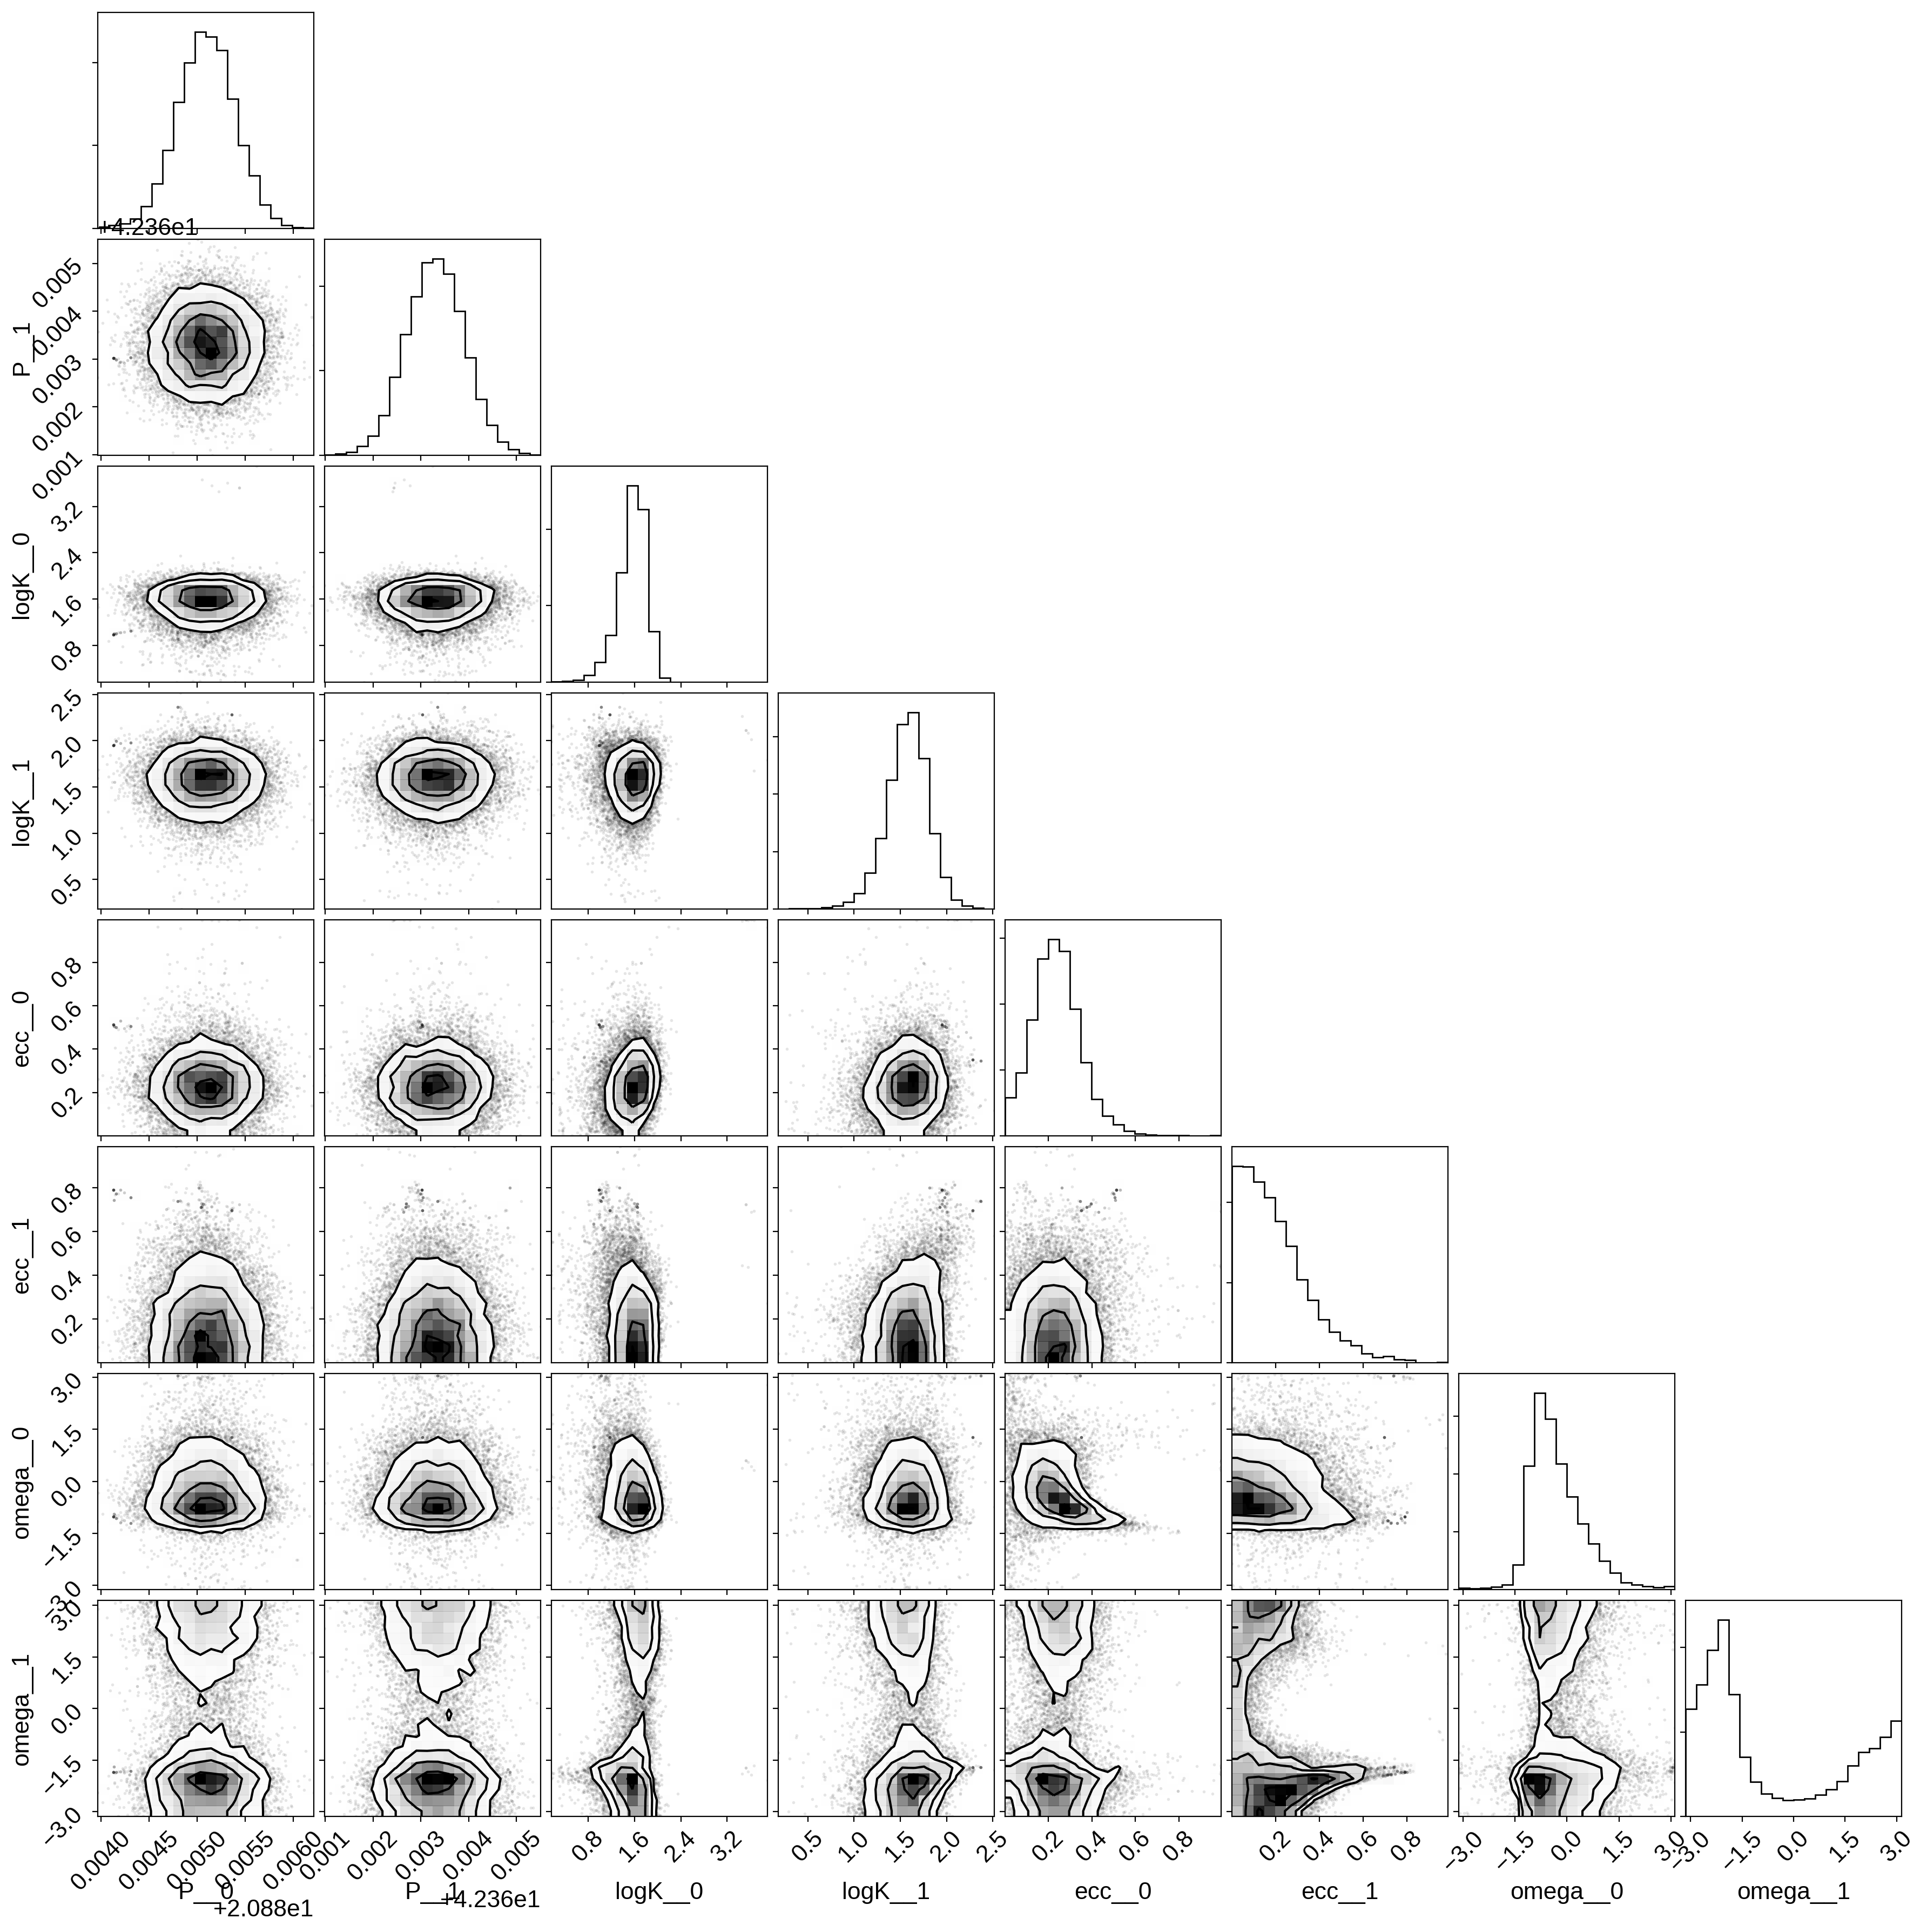

In [13]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

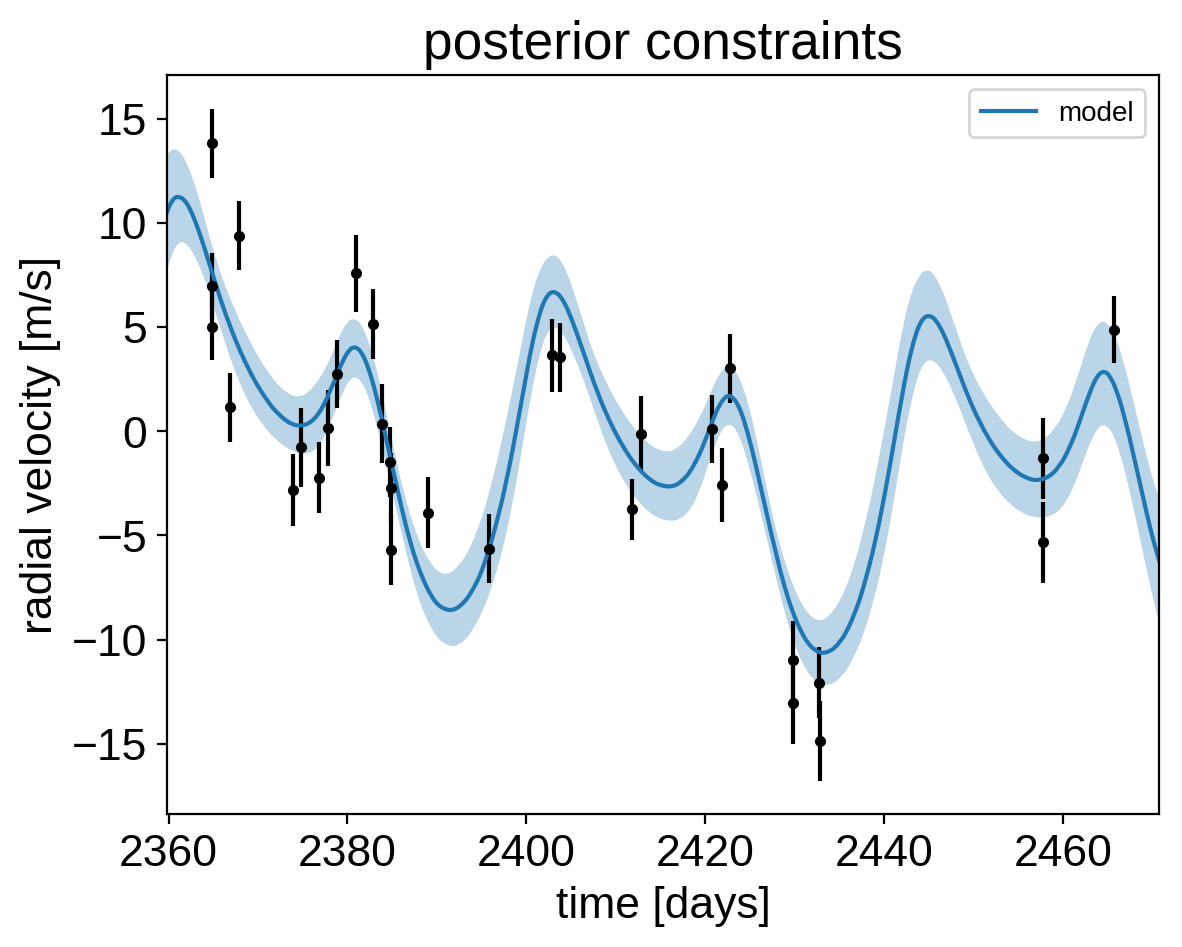

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

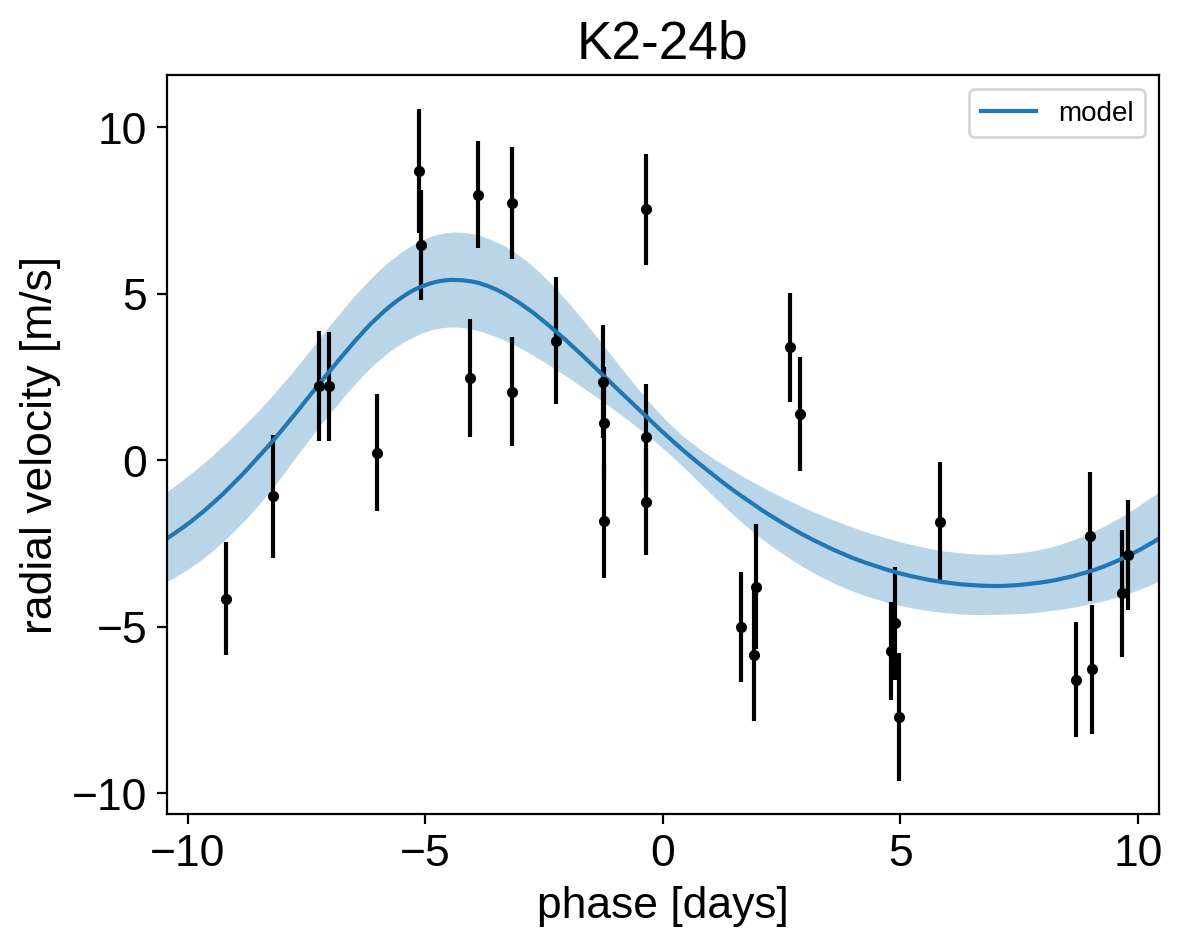

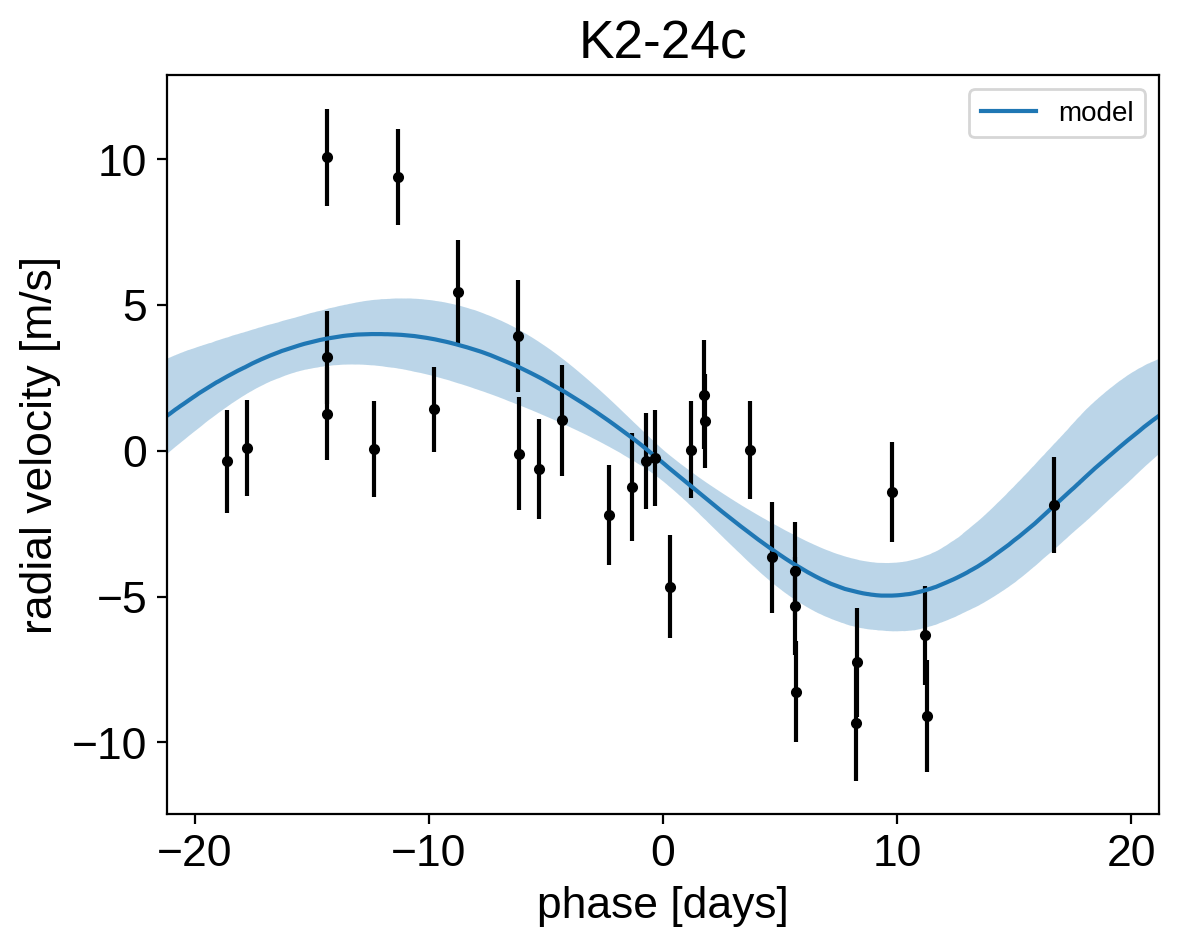

In [15]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
